<a href="https://colab.research.google.com/github/aydanazar/garbage_classification/blob/main/Classification_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import and Pre-Process Dataset

In [ ]:
## Import needed libraries

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cv2

from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans
from skimage.feature import hog
from skimage import exposure
from sklearn.decomposition import PCA
from scipy.cluster.vq import vq

from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV


from google.colab import drive
drive.mount('/content/drive')

### Download Dataset from Kaggle
Steps to Download Kaggle datasets in Google Colab:
https://www.kaggle.com/discussions/general/156610

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
# check for kaggle.json file
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Dec 10 18:19 kaggle.json


In [ ]:
# install kaggle API client
!pip install -q kaggle

# move it under a new kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# set permissions
!chmod 600 /root/.kaggle/kaggle.json

# check current directory (should be '/content')
!pwd

/content


In [ ]:
# list kaggle datasets
!kaggle datasets list

ref                                                                  title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                      DAIGT V2 Train Dataset                               29MB  2023-11-16 01:38:36           1516        155  1.0              
muhammadbinimran/housing-price-prediction-data                       Housing Price Prediction Data                       763KB  2023-11-21 17:56:32           6816        120  1.0              
thedevastator/netflix-imdb-scores                                    Netflix IMDB Scores                                 699KB  2023-12-03 14:10:34           2162         38  1.0              
andreinovikov/olympic-games        

In [ ]:
# download garbage classification dataset
!kaggle datasets download -d mostafaabla/garbage-classification

 96% 229M/239M [00:00<00:00, 255MB/s]
100% 239M/239M [00:01<00:00, 241MB/s]


In [ ]:
# unzip dataset to colab directory
!unzip garbage-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classification/pa

### Process Dataset as dataframe

In [ ]:
path = '/content/garbage_classification'

images= []
labels = []

# loop through directories and save images and labels to lists
for dirs in os.listdir(path):
  img_paths = glob.glob(path + '/' + dirs + '/*.jpg')
  for img in img_paths:
    labels.append(dirs)
    images.append(cv2.imread(img))

# convert to pandas dataframe
data_dict = {"image" : images, "class" : labels}
data_df = pd.DataFrame.from_dict(data_dict)
data_df.head()

image    class
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...  battery
1  [[[224, 223, 225], [224, 223, 225], [224, 223,...  battery
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...  battery
3  [[[37, 38, 48], [37, 38, 48], [37, 38, 48], [3...  battery
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...  battery

In [ ]:
# get count of images in each class
data_df['class'].value_counts()

clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: class, dtype: int64

In [ ]:
## Manage class imbalance: sample 1000 images from clothes and shoes
clothes_mask = data_df['class'] == 'clothes'
shoes_mask = data_df['class'] == 'shoes'

clothes_sampled = data_df[clothes_mask].sample(1000, random_state=42).reset_index(drop=True)
shoes_sampled = data_df[shoes_mask].sample(1000, random_state=42).reset_index(drop=True)

In [ ]:
data_df_masked = data_df[(~clothes_mask) & (~shoes_mask)]
data_df = pd.concat([data_df_masked, clothes_sampled, shoes_sampled])

# confirm 1000 records for clothes and shoes
data_df['class'].value_counts()

paper          1050
clothes        1000
shoes          1000
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: class, dtype: int64

In [ ]:
# save labels as csv
data_df['class'].to_csv('labels.csv', index=False)

## Feature Extraction
Skip if already complete and load vectors from csv's in "Load feature vectors from csv's" section

In [ ]:
def resize_img(img):
  '''Resize image to 200x200'''

  # resize image
  width = 200
  height = 200
  img_resize = cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)

  return img_resize

def hog_detection(img):
  ''' Convert image to grayscale, apply gaussian blur, and perform hog detection '''
  # convert image to grayscale
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # blur image using gaussian blur
  img_blur = cv2.GaussianBlur(src=img_gray, ksize=(3, 3), sigmaX=0)

  # extract hog features
  fd, img_hog = hog(img_blur, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), transform_sqrt=True, visualize=True)#, multichannel=True)

  # rescale hog intensity
  img_hog_rescale = exposure.rescale_intensity(img_hog, in_range=(0, 10))

  # return to RGB to use with matplotlib plotting
  img_og = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  return img_blur, img_hog_rescale

def bovw(imgs, n_words, k):
  ''' Takes a list of images as input and converts then into a bag of visual words
  Source Code: https://www.pinecone.io/learn/series/image-search/bag-of-visual-words/ '''

  # defining feature extractor that we want to use (SIFT)
  extractor = cv2.xfeatures2d.SIFT_create(n_words)

  # initialize lists where we will store *all* keypoints and descriptors
  keypoints = []
  descriptors = []

  for img in imgs:
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

  # set numpy seed for reproducability
  np.random.seed(0)
  # select 3000 random image index values (ignore due to balanced dataset size)
  #sample_idx = np.random.randint(0, len(imgs)+1, 3000).tolist()
  sample_idx = np.random.randint(0, len(imgs), len(imgs)).tolist()

  # extract the sample from descriptors
  # (we don't need keypoints)
  descriptors_sample = []

  for n in sample_idx:
    descriptors_sample.append(np.array(descriptors[n]))

  all_descriptors = []
  # extract image descriptor lists
  for img_descriptors in descriptors_sample:
    # extract specific descriptors within the image
    if img_descriptors.any():
      for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
  # convert to single numpy array
  all_descriptors = np.stack(all_descriptors)

  # perform k-means clustering to build the codebook

  iters = 1
  codebook, variance = kmeans(all_descriptors, k, iters)

  # vector quantization
  visual_words = []
  for img_descriptors in descriptors:
    # for each image, map each descriptor to the nearest codebook entry
    if isinstance(img_descriptors, np.ndarray):
      img_visual_words, distance = vq(img_descriptors, codebook)
      # if length of words in image less than n_words
      if img_visual_words.shape[0] < n_words:
        pad = n_words - img_visual_words.shape[0]
        img_visual_words = np.pad(img_visual_words, pad_width=(pad,), mode='constant')[pad:]
      # if length of words in image is greater than n_words
      elif img_visual_words.shape[0] > n_words:
        img_visual_words = img_visual_words[:n_words]
      img_words = np.array([codebook[i] for i in list(img_visual_words)])
      visual_words.append(img_words)# Create sample
    else:
      visual_words.append(np.zeros((n_words,128)))

  return codebook, visual_words

def color_detection(img, n_colors):
  ''' get dominant colors in image
  Source: https://www.geeksforgeeks.org/extract-dominant-colors-of-an-image-using-python/ '''

  # Get the dimensions (width, height, and depth) of the image
  w, h, d = tuple(img.shape)

  # Reshape image into a 2D array where each row represents a pixel
  pixel = np.reshape(img, (w * h, d))

  # desired number of clusters (number of dominant colors extracted)
  k = n_colors

  # Fit KMeans model to reshaped image
  model = KMeans(n_clusters=k, n_init=3, random_state=42).fit(pixel)

  # Get the cluster centers (representing colors) from the model
  dom_colors = [np.uint8(model.cluster_centers_)]

  return dom_colors

def bovc(imgs, n_colors, k):
  ''' Takes a list of images as input and converts then into a bag of colors
  Adapted from Bag of Visual Words Source Code: https://www.pinecone.io/learn/series/image-search/bag-of-visual-words/ '''

  all_colors = []

  # get dominant colors in each image
  for img in imgs:
    all_colors.append(color_detection(img, n_colors))
  # convert to single numpy array
  all_colors = np.stack(all_colors)
  all_colors_list = all_colors.reshape(all_colors.shape[0] * all_colors.shape[2], all_colors.shape[3])

  # perform k-means clustering to build the codebook

  # Fit KMeans model to reshaped image
  model = KMeans(n_clusters=k, n_init=3, random_state=42).fit(all_colors_list)

  # Get the cluster centers (representing colors) from the model
  codebook = np.array(np.uint8(model.cluster_centers_))

  # vector quantization
  img_colors = []
  for colors in all_colors:
    # for each image, map each color to the nearest codebook entry
    codebook_index, distance = vq(colors.reshape(n_colors, 3), codebook)
    img_clustered_colors = np.array([codebook[i] for i in list(codebook_index)])
    img_colors.append(img_clustered_colors)# Create sample

  return codebook, img_colors


In [ ]:
# extract blurred images and hogs
blurs = []
hogs = []
for index, row in data_df.iterrows():
  img = row['image']
  img_resized = resize_img(img)
  img_blur, img_hog = hog_detection(img_resized)
  blurs.append(img_blur)
  hogs.append(img_hog.flatten())

In [ ]:
# add to dataframe
data_df['blur'] = blurs
data_df['hog'] = hogs

In [ ]:
# implement bag of visual words
n_words = 20 # total visual words per image
k_means = 250 # total visual words in codebook
codebook, visual_words = bovw(blurs, n_words, k_means)

imgs_bovw = np.array(visual_words)
# save as numpy file
np.save('imgs_bovw.npy', imgs_bovw)

In [ ]:
# add to dataframe
data_df['bovw'] = visual_words
data_df.head()

image    class  \
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...  battery   
1  [[[224, 223, 225], [224, 223, 225], [224, 223,...  battery   
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...  battery   
3  [[[37, 38, 48], [37, 38, 48], [37, 38, 48], [3...  battery   
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...  battery   

                                               bovc  \
0  [[111, 116, 120], [13, 14, 16], [252, 252, 252]]   
1   [[228, 229, 229], [75, 145, 61], [75, 145, 61]]   
2  [[252, 252, 252], [111, 116, 120], [53, 52, 52]]   
3  [[41, 40, 40], [228, 229, 229], [140, 144, 146]]   
4  [[252, 252, 252], [39, 35, 138], [131, 99, 193]]   

                                                blur  \
0  [[255, 255, 255, 254, 253, 253, 253, 248, 224,...   
1  [[224, 224, 224, 224, 224, 224, 224, 224, 224,...   
2  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   
3  [[41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, ...   
4  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   

                                                 hog  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                bovw  
0  [[11.017208, 5.5181646, 5.8986616, 12.259082, ...  
1  [[11.646026, 6.1876154, 6.0896487, 6.484288, 9...  
2  [[13.888778, 140.7064, 66.33667, 3.5721443, 1....  
3  [[24.290037, 17.709963, 9.96343, 12.529634, 7....  
4  [[4.386399, 13.843895, 58.672333, 78.55796, 28...

In [ ]:
# implement bag of visual colors
n_colors = 3 # total dominant colors per image
k_means = 75 # total colors in codebook
codebook, colors = bovc(list(data_df['image']), n_colors, k_means)

imgs_bovc = np.array(colors)
# save to numpy file
np.save("imgs_bovc.npy", imgs_bovc)

In [ ]:
# add to dataframe
data_df['bovc'] = colors
data_df.head()

image    class  \
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...  battery   
1  [[[224, 223, 225], [224, 223, 225], [224, 223,...  battery   
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...  battery   
3  [[[37, 38, 48], [37, 38, 48], [37, 38, 48], [3...  battery   
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...  battery   

                                               bovc  
0  [[111, 116, 120], [13, 14, 16], [252, 252, 252]]  
1   [[228, 229, 229], [75, 145, 61], [75, 145, 61]]  
2  [[252, 252, 252], [111, 116, 120], [53, 52, 52]]  
3  [[41, 40, 40], [228, 229, 229], [140, 144, 146]]  
4  [[252, 252, 252], [39, 35, 138], [131, 99, 193]]

### PCA
Skip if already complete and load vectors from csv's in "Load feature vectors from csv's" section

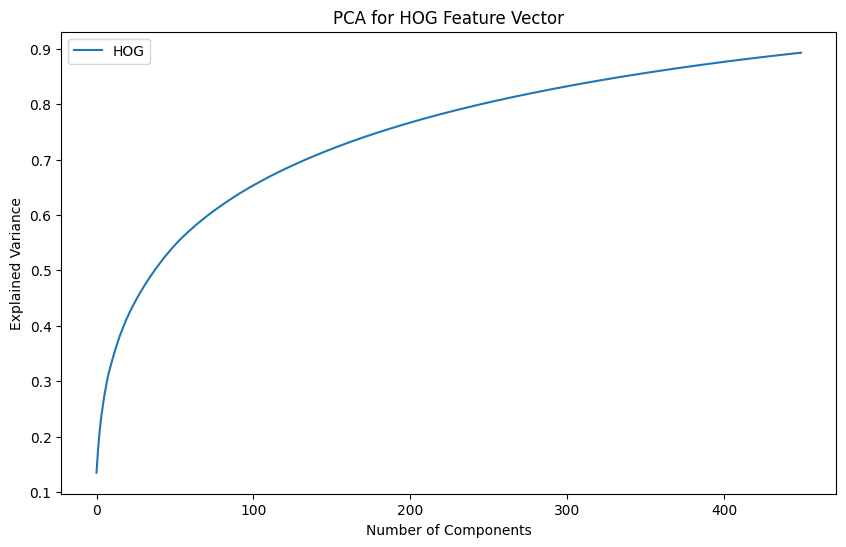

In [ ]:
def feature_pca(features, num_components, feature_name, pca_col):
  # Convert lists to numpy arrays
  X = np.array(features)
  y = np.array(data_df['class'])

  # PCA
  pca = PCA(n_components=num_components)
  X_pca = pca.fit_transform(X)

  # Plot the explained variance
  explained_variance_ratios = pca.explained_variance_ratio_.cumsum()

  plt.figure(figsize=(10, 6))

  # Plot explained variance for each component
  plt.plot(range(num_components), explained_variance_ratios, label=feature_name)

  # Add labels and legend
  plt.title('PCA for ' + feature_name + ' Feature Vector')
  plt.xlabel('Number of Components')
  plt.ylabel('Explained Variance')
  plt.legend()
  plt.show()

  # add to dataframe
  data_df[pca_col] = X_pca.tolist()
  imgs_hog_pca = X_pca
  np.savetxt('imgs_hog_pca.csv', imgs_hog_pca, delimiter=',')


feature_pca(hogs, 450, "HOG", "hog_pca")

# note: no PCA on BOVW needed because kmeans clustering already achieves this

In [ ]:
# resulting dataframe
data_df.head()

image    class  \
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...  battery   
1  [[[224, 223, 225], [224, 223, 225], [224, 223,...  battery   
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...  battery   
3  [[[37, 38, 48], [37, 38, 48], [37, 38, 48], [3...  battery   
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...  battery   

                                             hog_pca  \
0  [2.189156354441641, 0.7400468735375466, -0.663...   
1  [-0.6218759585863919, -0.2459165625116312, 0.0...   
2  [-0.27365468556605543, 0.6007934622690123, 0.0...   
3  [0.29577646577267, -0.16461600332483664, -0.06...   
4  [0.2014304849449809, 0.2116504775821551, -0.01...   

                                                blur  \
0  [[255, 255, 255, 254, 253, 253, 253, 248, 224,...   
1  [[224, 224, 224, 224, 224, 224, 224, 224, 224,...   
2  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   
3  [[41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, ...   
4  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   

                                                 hog  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                bovw  
0  [47, 349, 493, 493, 412, 493, 488, 383, 23, 34...  
1  [132, 50, 351, 351, 69, 247, 392, 107, 24, 97,...  
2  [105, 229, 88, 431, 41, 445, 229, 337, 403, 66...  
3  [160, 201, 322, 413, 76, 92, 201, 277, 400, 20...  
4  [50, 172, 382, 134, 50, 375, 428, 351, 230, 13...

## Load feature vectors from csv's

In [ ]:
# path to dataset and feature vector csv's
path = '/content/drive/MyDrive/W281/Processed_Dataset_Feature_Vector_CSVs/'

# load labels
data_df = pd.read_csv(path + 'labels.csv')

# load resnet feature vector
resnet_features = np.load(path + 'imgs_resnet.npy')
data_df['resnet'] = list(resnet_features)

# load hog pca feature vector
hog_pca = np.loadtxt(path + 'imgs_hog_pca450.csv', delimiter=',')
data_df['hog_pca'] = list(hog_pca)

# load bovw feature vector
visual_words = np.load(path + 'imgs_bovw_n20_k250.npy')
data_df['bovw'] = list(visual_words)

# load bovc feature vector
color_file = np.load(path + 'imgs_bovc.npy')
data_df['bovc'] = list(color_file)

In [ ]:
# resulting dataframe
data_df.head()

class                                             resnet  \
0  battery  [0.0, 0.3818555, 0.0, 0.06290764, 0.08147252, ...   
1  battery  [0.43193766, 0.38143426, 0.35062382, 0.0059453...   
2  battery  [0.100634456, 1.5973613, 0.06269982, 0.0, 0.0,...   
3  battery  [0.08150741, 0.38641408, 0.0, 0.0, 0.007759203...   
4  battery  [1.3157188, 1.047845, 0.14115347, 0.019219099,...   

                                             hog_pca  \
0  [2.189156354441641, 0.7400468735375466, -0.663...   
1  [-0.6218759585863919, -0.2459165625116312, 0.0...   
2  [-0.27365468556605543, 0.6007934622690123, 0.0...   
3  [0.29577646577267, -0.16461600332483664, -0.06...   
4  [0.2014304849449809, 0.2116504775821551, -0.01...   

                                                bovw  \
0  [[11.017208099365234, 5.51816463470459, 5.8986...   
1  [[11.646025657653809, 6.187615394592285, 6.089...   
2  [[13.888777732849121, 140.70640563964844, 66.3...   
3  [[24.290037155151367, 17.709962844848633, 9.96...   
4  [[4.386398792266846, 13.843894958496094, 58.67...   

                                               bovc  
0  [[111, 116, 120], [13, 14, 16], [252, 252, 252]]  
1   [[228, 229, 229], [75, 145, 61], [75, 145, 61]]  
2  [[252, 252, 252], [111, 116, 120], [53, 52, 52]]  
3  [[41, 40, 40], [228, 229, 229], [140, 144, 146]]  
4  [[252, 252, 252], [39, 35, 138], [131, 99, 193]]

## t-SNE

In [ ]:
def tsne_viz(df, feature_vector, perplexity, learning_rate, max_iter):

  ### Set up tSNE and fit to feature vector
  tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=max_iter)
  tsne_results = tsne.fit_transform(feature_vector)


  ## plotting t-SNE chart
  data_tSNE = df
  data_tSNE["t-SNE-1"] = tsne_results[:,0]
  data_tSNE["tSNE-2"] = tsne_results[:,1]

  plt.figure(figsize=(10,8))
  sns.scatterplot(
      x="t-SNE-1", y="tSNE-2",
      hue="class",
      palette=sns.color_palette("hls", 12),
      data=data_tSNE,
      legend="full",
      alpha=0.3
  )
  plt.show()

<ipython-input-86-3998988ea88b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tSNE["t-SNE-1"] = tsne_results[:,0]


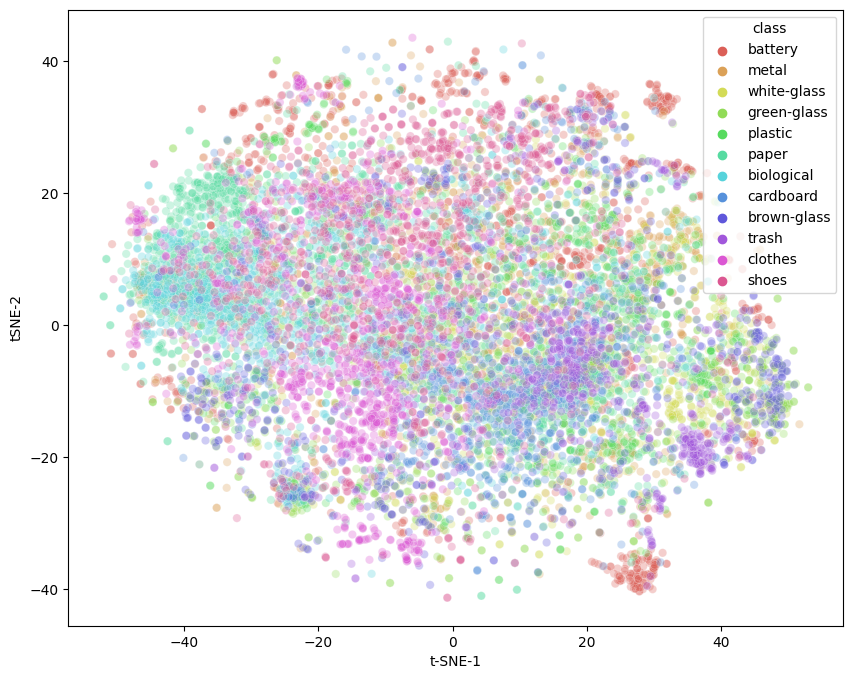

In [ ]:
### T-SNE on HOG PCA feature vector
hog_vector = np.array([list(x) for x in data_df['hog_pca']])
tsne_viz(data_df[['class', 'hog_pca']], hog_vector, 50, 300, 1000)

<ipython-input-86-3998988ea88b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tSNE["t-SNE-1"] = tsne_results[:,0]


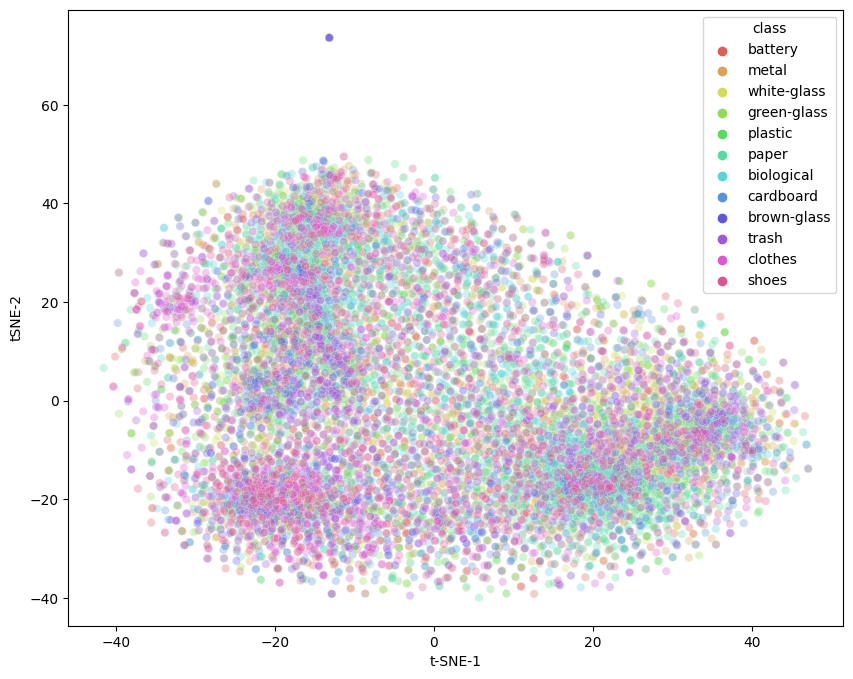

In [ ]:
### T-SNE on BOVW feature vector
bovw_vector = np.array([x.flatten() for x in data_df['bovw']])
tsne_viz(data_df[['class', 'bovw']], bovw_vector, 50, 1000, 2000)

<ipython-input-86-3998988ea88b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tSNE["t-SNE-1"] = tsne_results[:,0]


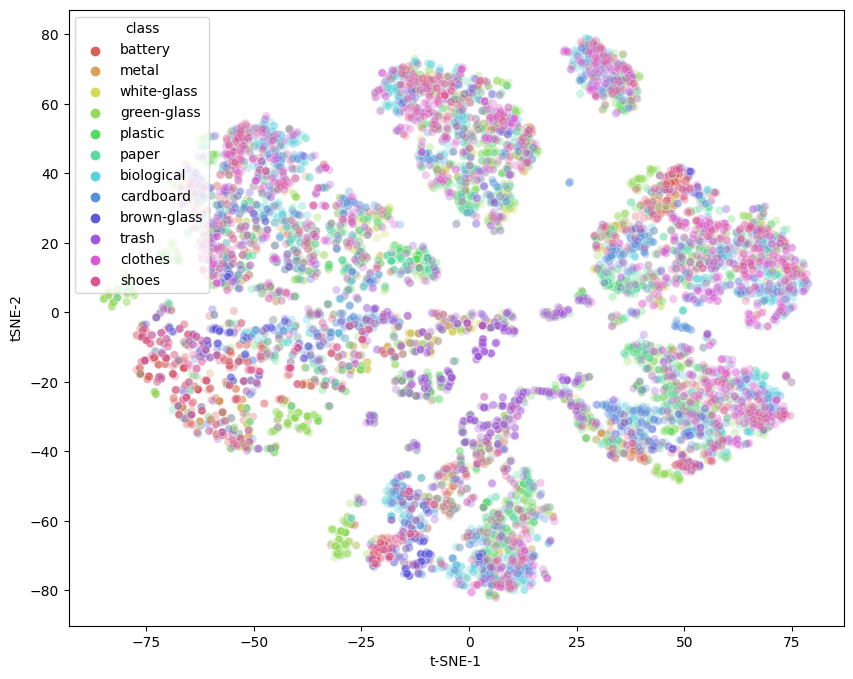

In [ ]:
### T-SNE on BOVC feature vector
bovc_vector = np.array([x.flatten() for x in data_df['bovc']])
tsne_viz(data_df[['class', 'bovc']], bovc_vector, 50, 'auto', 1000)

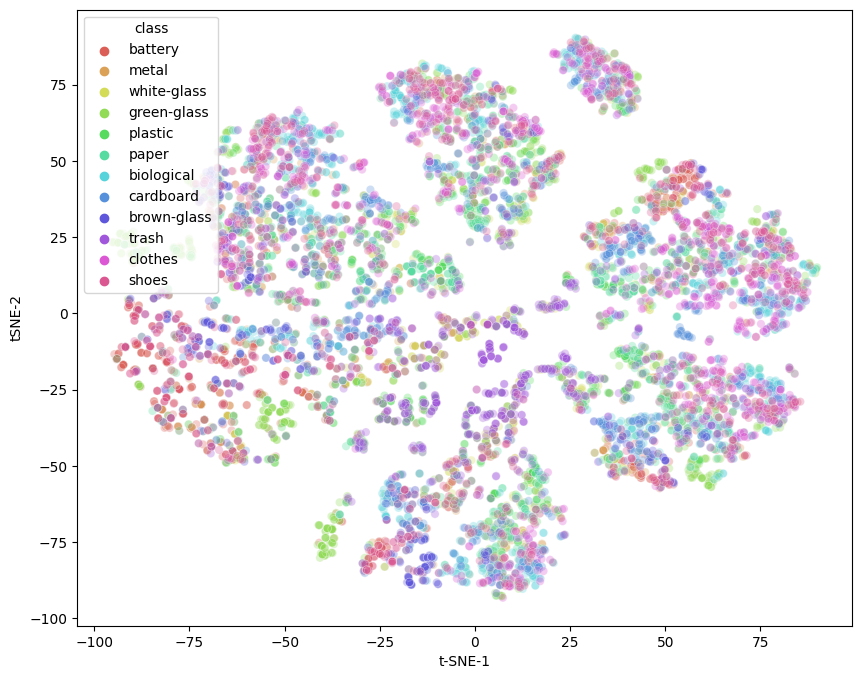

In [ ]:
### T-SNE on HOG PCA + BOVC concat feature vector
concat_vector = np.array([np.hstack([x['hog_pca'], x['bovc'].flatten()]) for i, x in data_df.iterrows()])
tsne_viz(data_df[['class', 'hog_pca', 'bovc']], concat_vector, 30, 'auto', 1000)

## Split into Train, Test, Val

In [ ]:
# split into train, validation, and test (70%, 10%, 20%)
train, val, test = np.split(data_df.sample(frac=1, random_state=42),
                       [int(.7*len(data_df)), int(.8*len(data_df))])

print("Number of Images:")
print("Train:", len(train))
print("Validation:", len(val))
print("Test:", len(test))

Number of Images:
Train: 7149
Validation: 1021
Test: 2043


In [ ]:
# samples in train per class
train.groupby('class').size()

class
battery        678
biological     682
brown-glass    413
cardboard      614
clothes        703
green-glass    445
metal          546
paper          753
plastic        618
shoes          680
trash          480
white-glass    537
dtype: int64

In [ ]:
# samples in validation per class
val.groupby('class').size()

class
battery         83
biological     104
brown-glass     52
cardboard       98
clothes        102
green-glass     56
metal           66
paper           92
plastic         79
shoes          116
trash           77
white-glass     96
dtype: int64

In [ ]:
# samples in test per class
test.groupby('class').size()

class
battery        184
biological     199
brown-glass    142
cardboard      179
clothes        195
green-glass    128
metal          157
paper          205
plastic        168
shoes          204
trash          140
white-glass    142
dtype: int64

## Classification

### HOG PCA 450 Components

In [ ]:
# extract x and y variables
X_train = np.array([list(x) for x in train['hog_pca']])
y_train = np.array(train['class'])

X_val = np.array([list(x) for x in val['hog_pca']])
y_val = np.array(val['class'])

X_test = np.array([list(x) for x in test['hog_pca']])
y_test = np.array(test['class'])

In [ ]:
# train logistic regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [ ]:
# validation set predictions, accuracy, and classification report
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, model.predict(X_val)))

Accuracy: 0.43290891283055827

Classification Report:

              precision    recall  f1-score   support

     battery       0.48      0.49      0.49        83
  biological       0.56      0.48      0.52       104
 brown-glass       0.41      0.25      0.31        52
   cardboard       0.46      0.51      0.48        98
     clothes       0.55      0.58      0.56       102
 green-glass       0.29      0.18      0.22        56
       metal       0.25      0.21      0.23        66
       paper       0.45      0.53      0.49        92
     plastic       0.24      0.29      0.26        79
       shoes       0.52      0.52      0.52       116
       trash       0.41      0.58      0.48        77
 white-glass       0.37      0.29      0.33        96

    accuracy                           0.43      1021
   macro avg       0.41      0.41      0.41      1021
weighted avg       0.43      0.43      0.43      1021



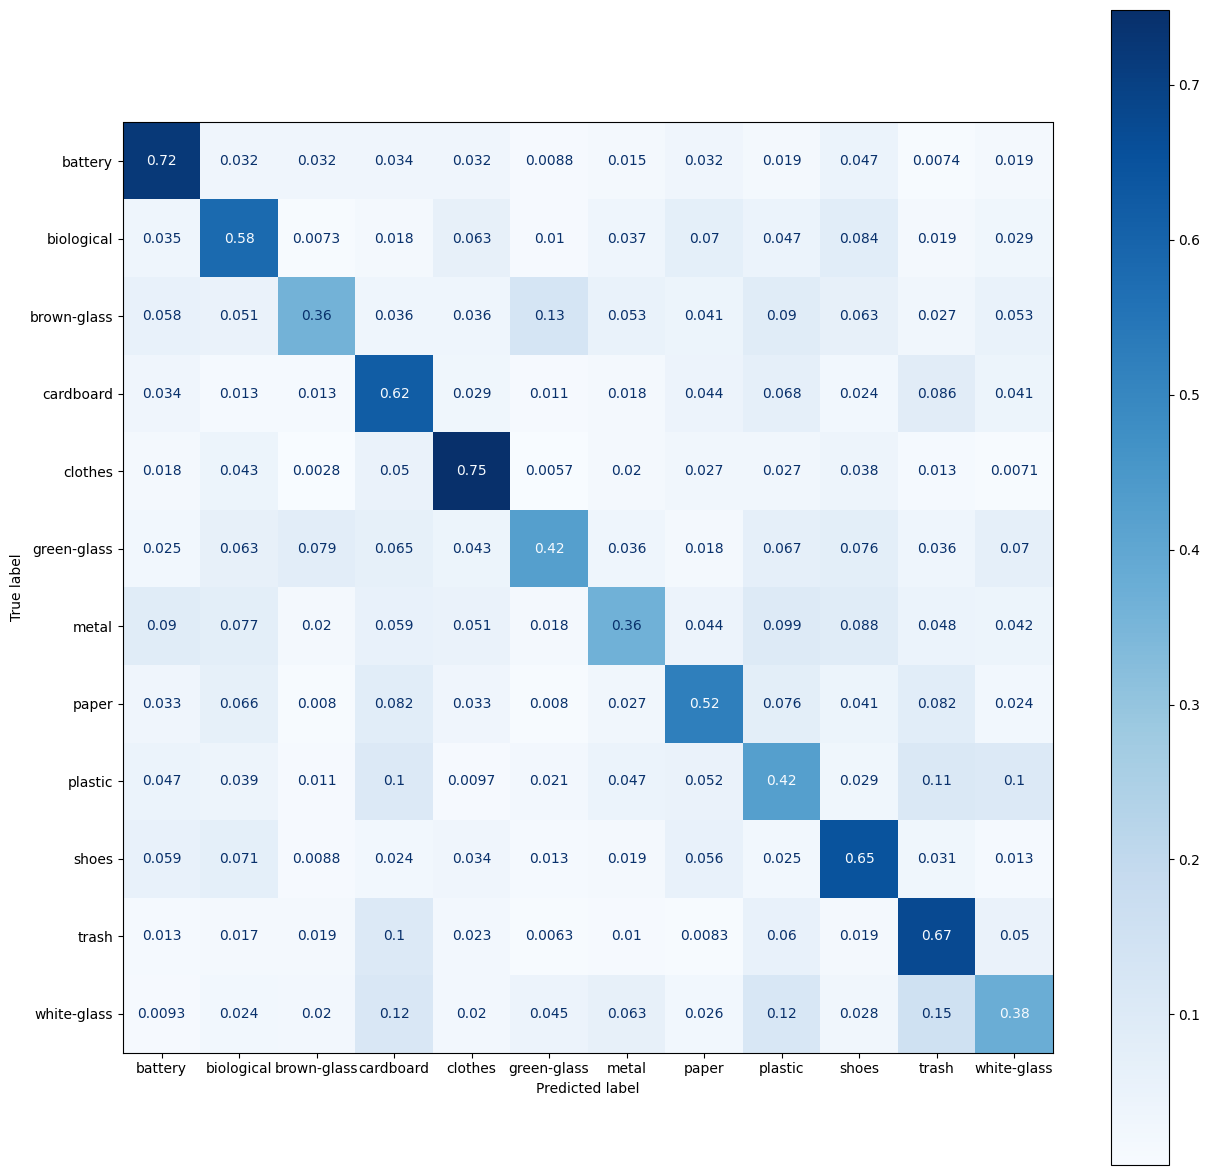

In [ ]:
# normalized confusion matrix on training
y_train_pred = model.predict(X_train)

fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap='Blues', normalize='true', ax=ax)

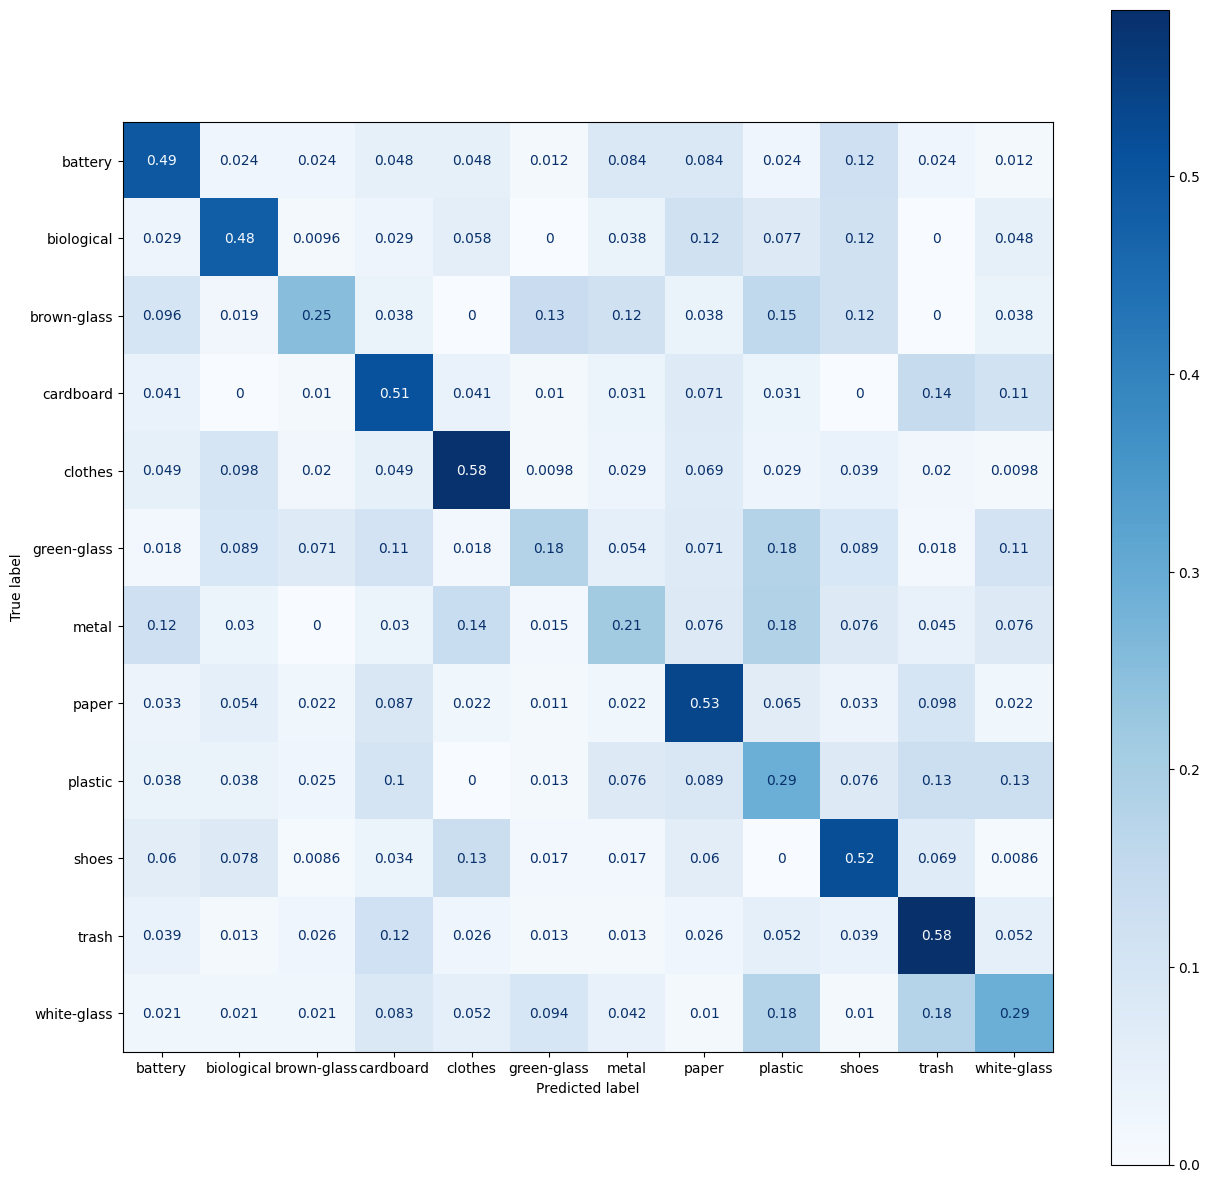

In [ ]:
# normalized confusion matrix on validation
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues', normalize='true', ax=ax)

### BOVW (n_words = 20, k_means = 250)

In [ ]:
# extract x and y variables
X_train = np.array([x.flatten() for x in train['bovw']])
y_train = np.array(train['class'])

X_val = np.array([x.flatten() for x in val['bovw']])
y_val = np.array(val['class'])

X_test = np.array([x.flatten() for x in test['bovw']])
y_test = np.array(test['class'])

In [ ]:
# train logistic regression model
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000)

In [ ]:
# validation set predictions, accuracy, and classification report
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, model.predict(X_val)))

Accuracy: 0.19686581782566112

Classification Report:

              precision    recall  f1-score   support

     battery       0.21      0.16      0.18        83
  biological       0.30      0.29      0.30       104
 brown-glass       0.11      0.13      0.12        52
   cardboard       0.17      0.18      0.18        98
     clothes       0.21      0.20      0.20       102
 green-glass       0.12      0.12      0.12        56
       metal       0.08      0.08      0.08        66
       paper       0.25      0.30      0.28        92
     plastic       0.12      0.14      0.13        79
       shoes       0.20      0.17      0.19       116
       trash       0.20      0.21      0.21        77
 white-glass       0.27      0.27      0.27        96

    accuracy                           0.20      1021
   macro avg       0.19      0.19      0.19      1021
weighted avg       0.20      0.20      0.20      1021



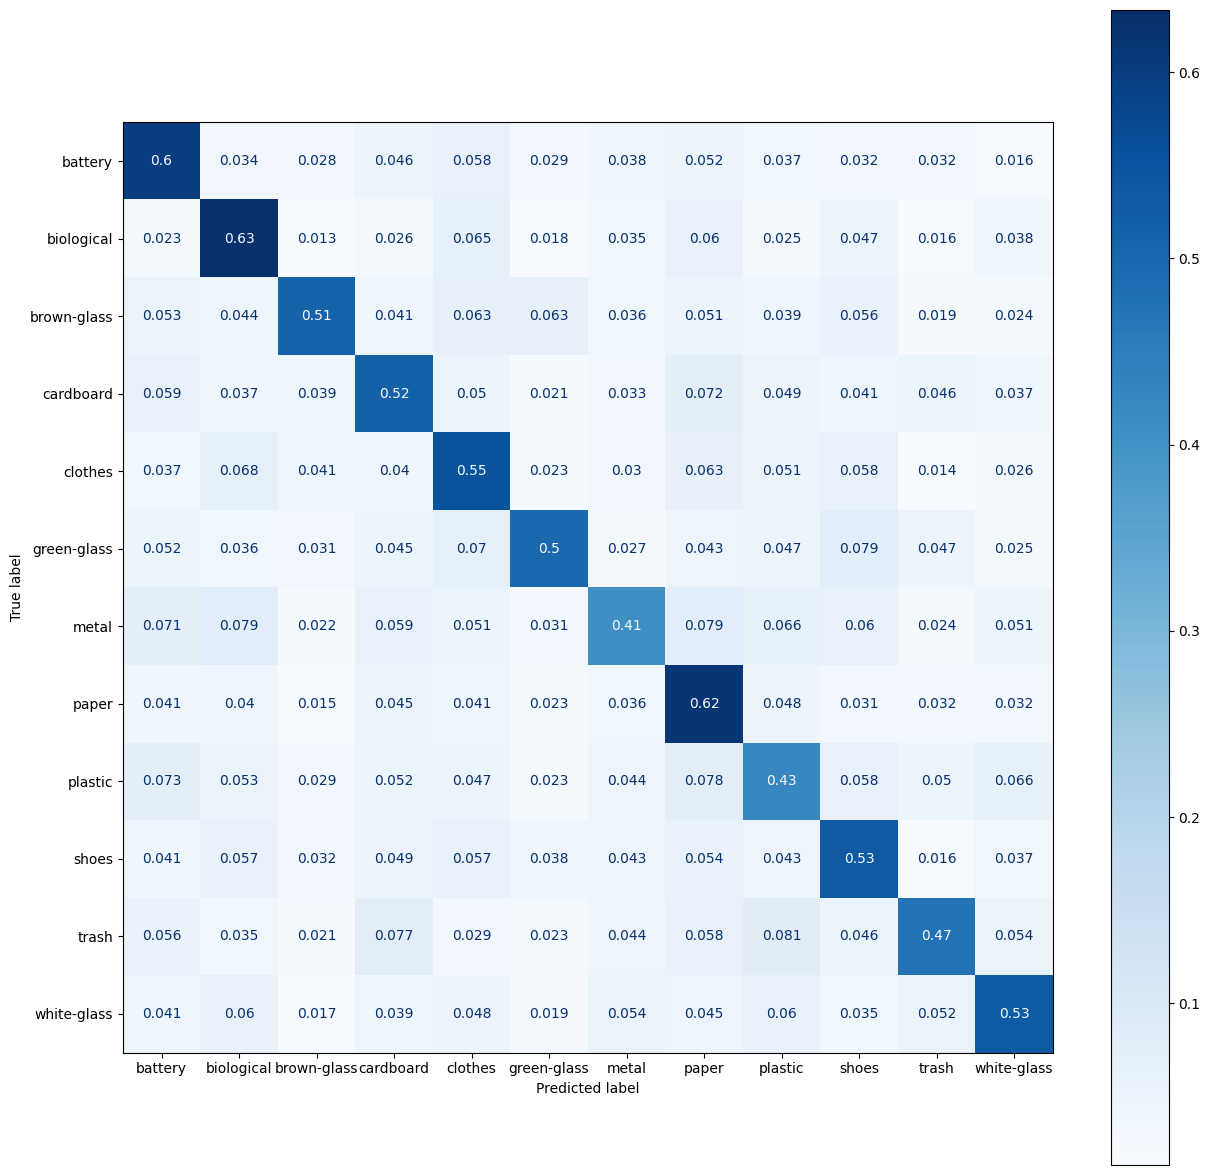

In [ ]:
# normalized confusion matrix on train
y_train_pred = model.predict(X_train)
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap='Blues', normalize='true', ax=ax)

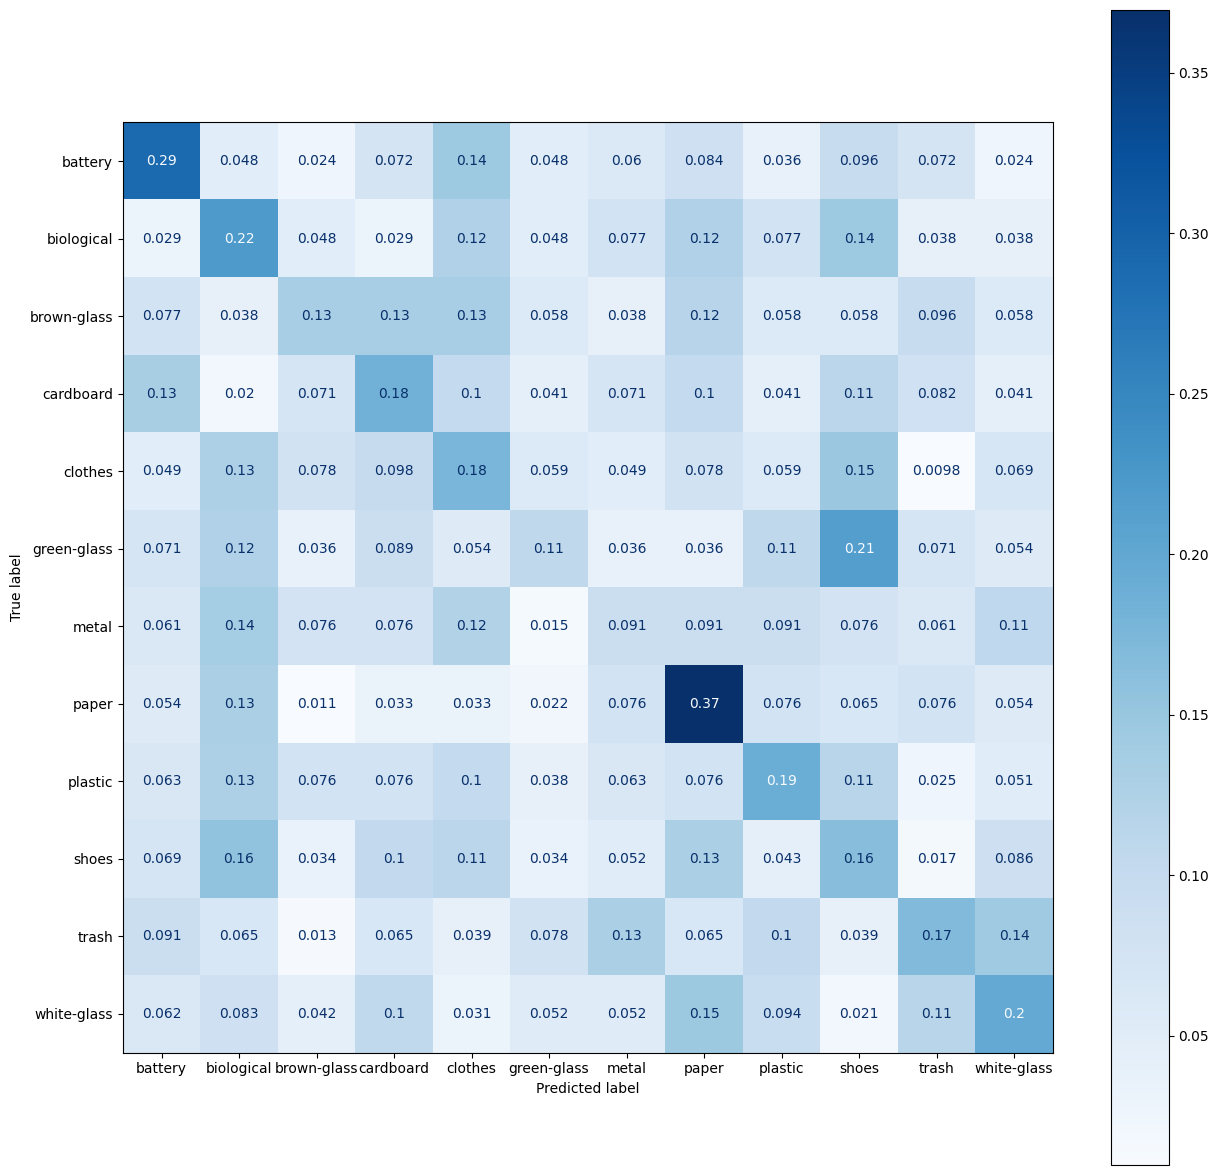

In [ ]:
# normalized confusion matrix on validation
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues', normalize='true', ax=ax)

### BOVC

In [ ]:
# extract x and y variables
X_train = np.array([x.flatten() for x in train['bovc']])
y_train = np.array(train['class'])

X_val = np.array([x.flatten() for x in val['bovc']])
y_val = np.array(val['class'])

X_test = np.array([x.flatten() for x in test['bovc']])
y_test = np.array(test['class'])

In [ ]:
# train logistic regression model
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [ ]:
# validation set predictions, accuracy, and classification report
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, model.predict(X_val)))

Accuracy: 0.34476003917727716

Classification Report:

              precision    recall  f1-score   support

     battery       0.28      0.52      0.36        83
  biological       0.38      0.45      0.41       104
 brown-glass       0.43      0.23      0.30        52
   cardboard       0.36      0.41      0.38        98
     clothes       0.27      0.35      0.30       102
 green-glass       0.83      0.86      0.84        56
       metal       0.00      0.00      0.00        66
       paper       0.25      0.32      0.28        92
     plastic       0.37      0.27      0.31        79
       shoes       0.08      0.03      0.05       116
       trash       0.46      0.66      0.54        77
 white-glass       0.28      0.22      0.25        96

    accuracy                           0.34      1021
   macro avg       0.33      0.36      0.34      1021
weighted avg       0.31      0.34      0.32      1021



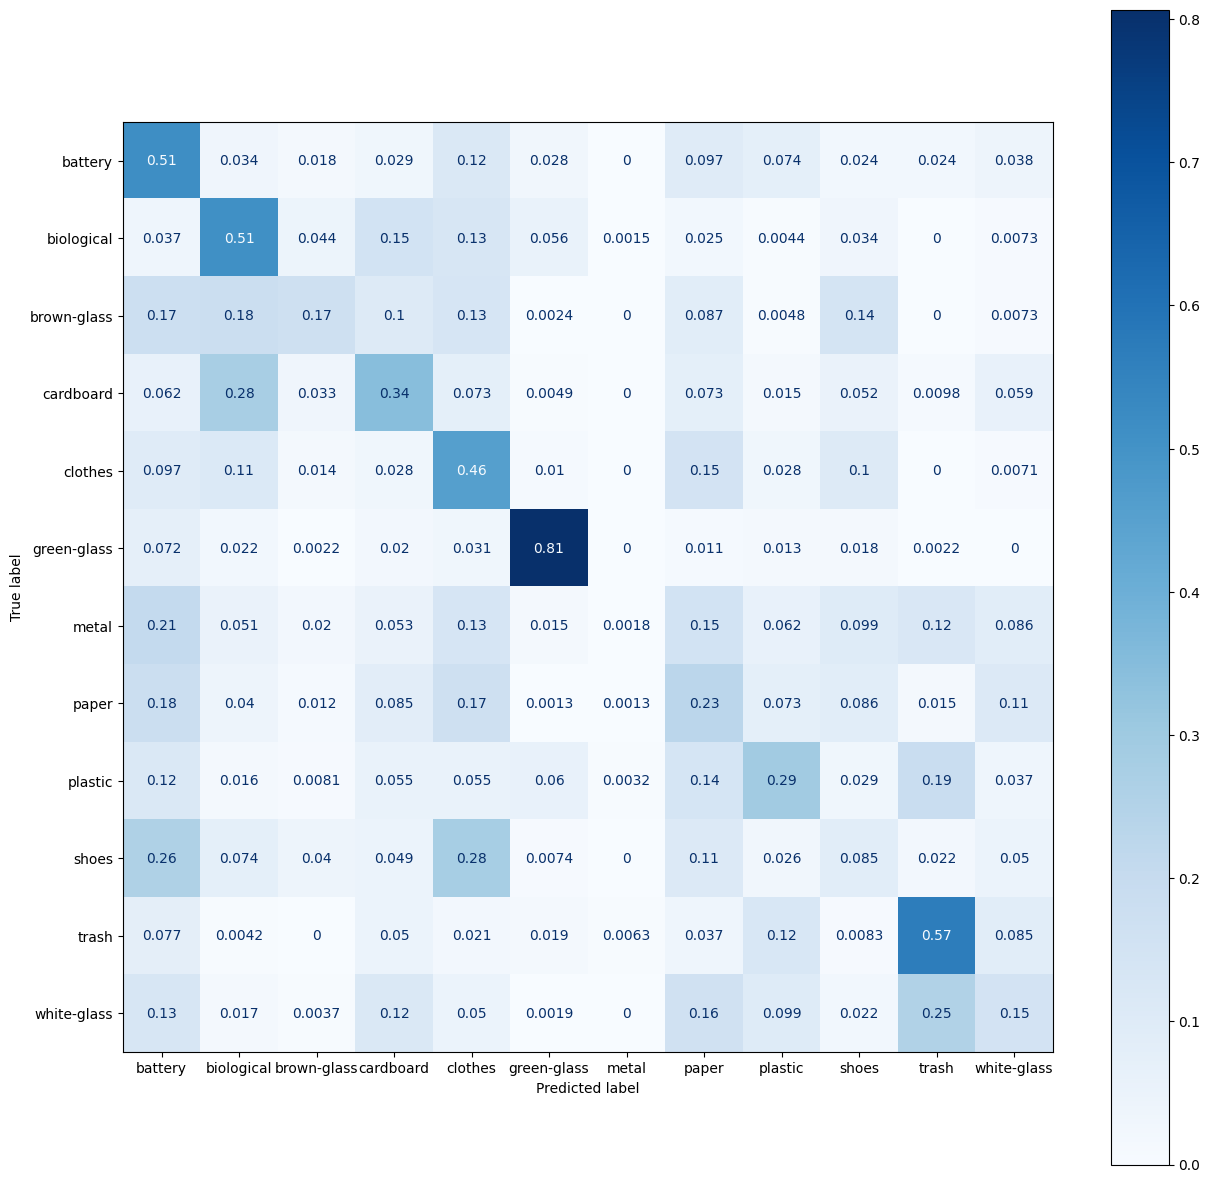

In [ ]:
# normalized confusion matrix on train
y_train_pred = model.predict(X_train)
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap='Blues', normalize='true', ax=ax)

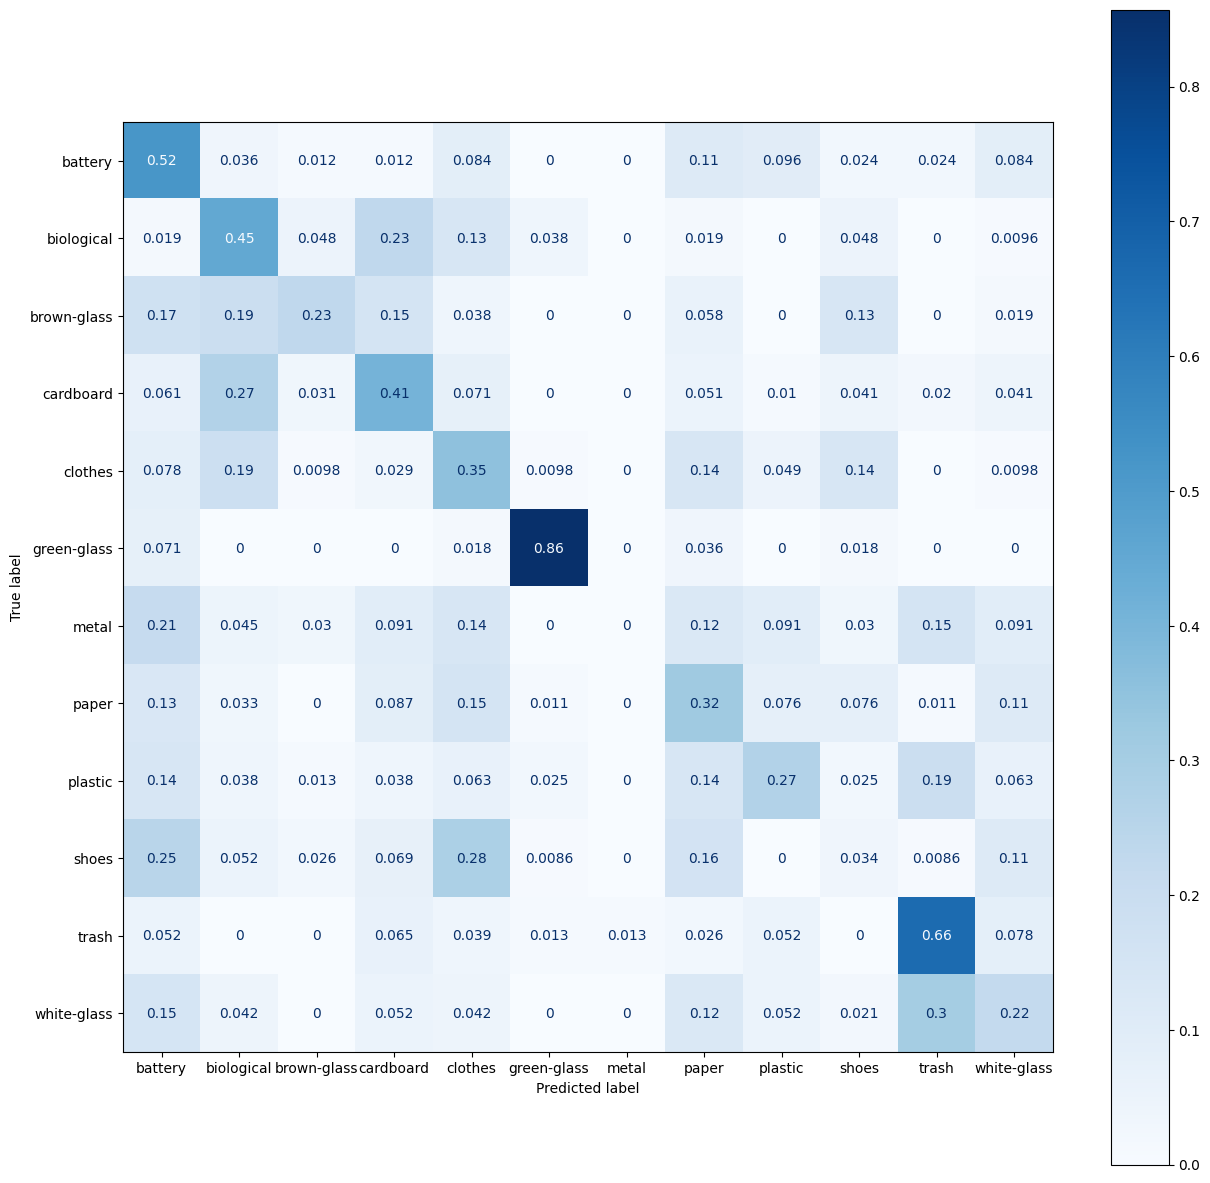

In [ ]:
# normalized confusion matrix on validation
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues', normalize='true', ax=ax)

### HOG + BOVC Concat

In [ ]:
# extract x and y variables
X_train = np.array([np.hstack([x['hog_pca'], x['bovc'].flatten()]) for i, x in train.iterrows()])
y_train = np.array(train['class'])

X_val = np.array([np.hstack([x['hog_pca'], x['bovc'].flatten()]) for i, x in val.iterrows()])
y_val = np.array(val['class'])

X_test = np.array([np.hstack([x['hog_pca'], x['bovc'].flatten()]) for i, x in test.iterrows()])
y_test = np.array(test['class'])

In [ ]:
# train logistic regression model
model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
# validation set predictions, accuracy, and classification report
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, model.predict(X_val)))

Accuracy: 0.5377081292850147

Classification Report:

              precision    recall  f1-score   support

     battery       0.59      0.58      0.58        83
  biological       0.68      0.66      0.67       104
 brown-glass       0.57      0.38      0.46        52
   cardboard       0.53      0.71      0.61        98
     clothes       0.56      0.63      0.59       102
 green-glass       0.85      0.79      0.81        56
       metal       0.29      0.24      0.26        66
       paper       0.46      0.52      0.49        92
     plastic       0.34      0.37      0.35        79
       shoes       0.65      0.52      0.57       116
       trash       0.51      0.60      0.55        77
 white-glass       0.45      0.36      0.40        96

    accuracy                           0.54      1021
   macro avg       0.54      0.53      0.53      1021
weighted avg       0.54      0.54      0.53      1021



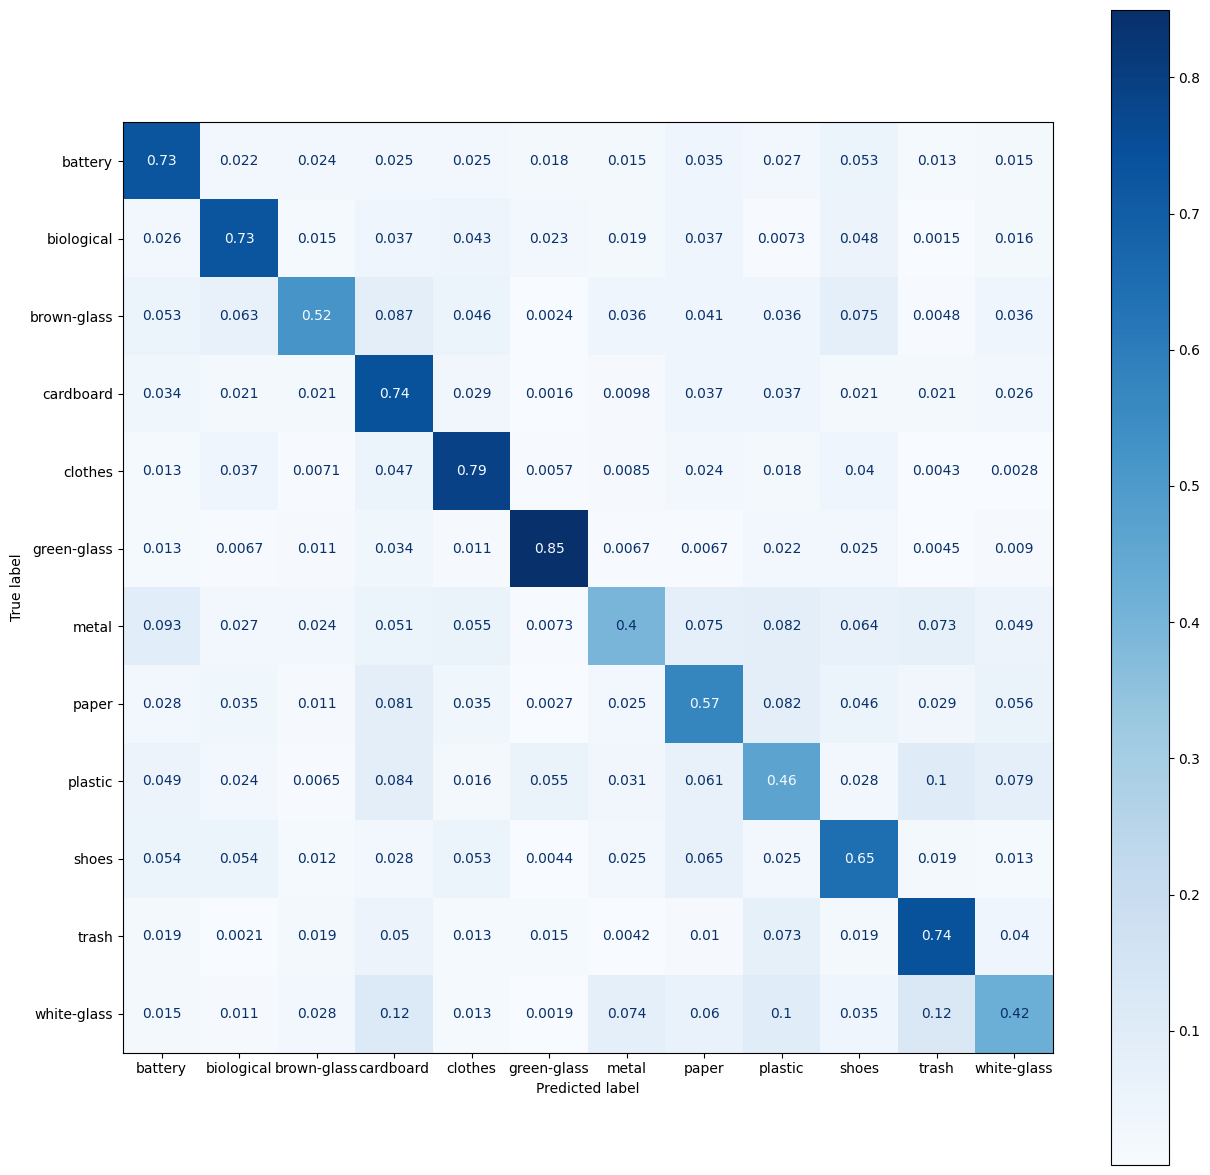

In [ ]:
# normalized confusion matrix on train
y_train_pred = model.predict(X_train)
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap='Blues', normalize='true', ax=ax)

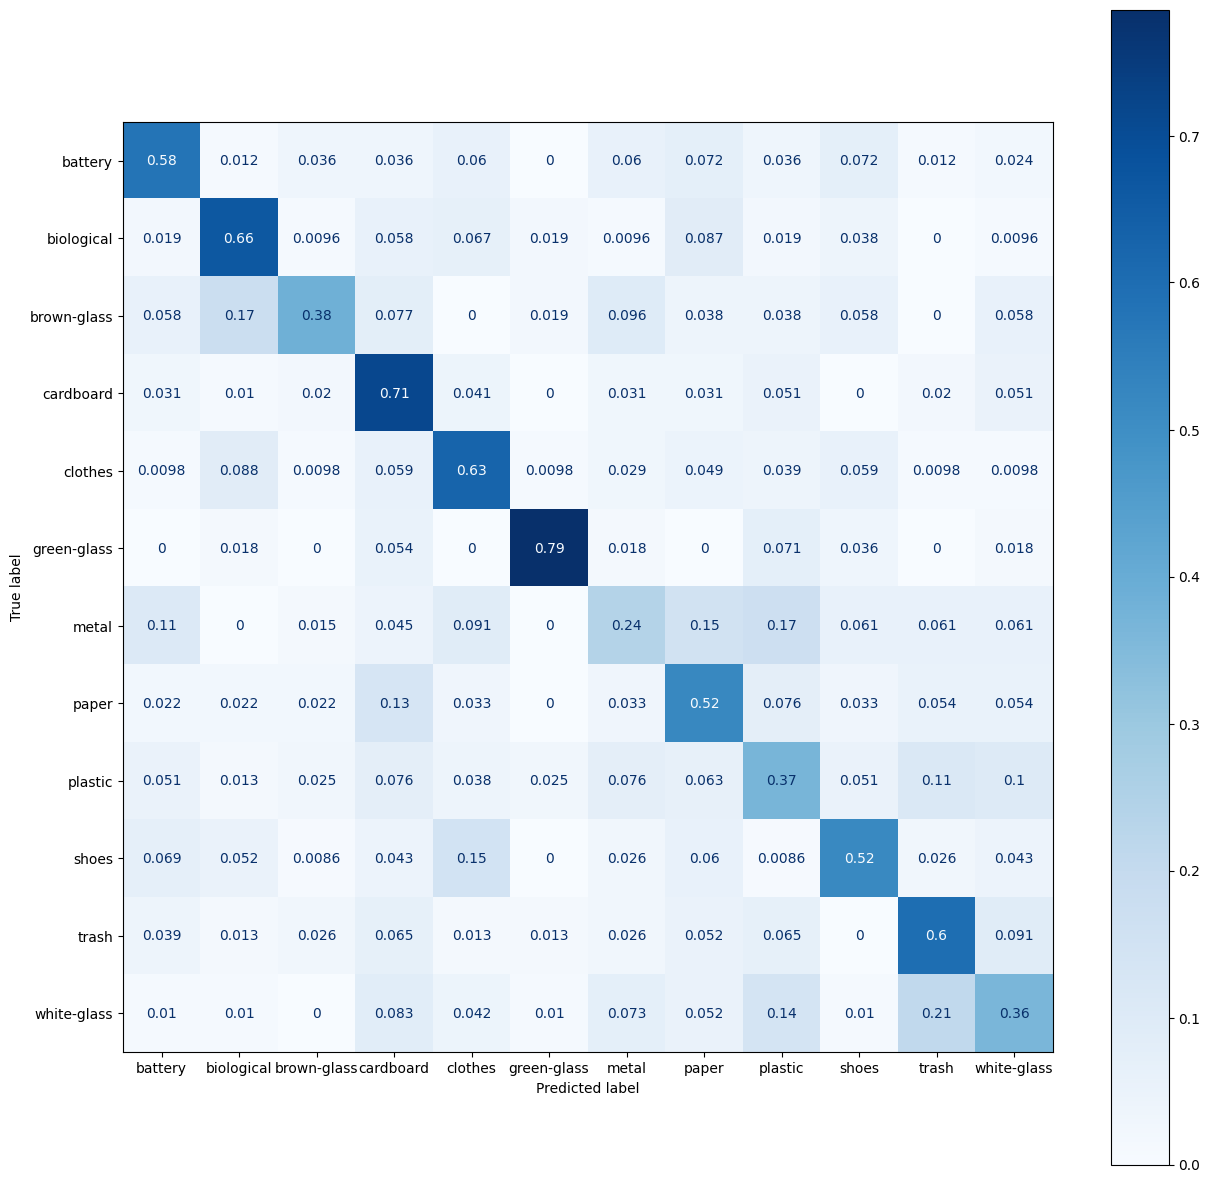

In [ ]:
# normalized confusion matrix on validation
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues', normalize='true', ax=ax)

### ResNet

In [ ]:
# extract x and y variables
X_train = np.array([list(x) for x in train['resnet']])
y_train = np.array(train['class'])

X_val = np.array([list(x) for x in val['resnet']])
y_val = np.array(val['class'])

X_test = np.array([list(x) for x in test['resnet']])
y_test = np.array(test['class'])

In [ ]:
# train logistic regression model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [ ]:
# validation set predictions, accuracy, and classification report
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, model.predict(X_val)))

Accuracy: 0.6895200783545543

Classification Report:

              precision    recall  f1-score   support

     battery       0.88      0.89      0.89        83
  biological       0.59      0.62      0.61       104
 brown-glass       0.23      0.31      0.26        52
   cardboard       0.54      0.45      0.49        98
     clothes       0.99      0.98      0.99       102
 green-glass       0.43      0.59      0.50        56
       metal       0.78      0.79      0.78        66
       paper       0.55      0.49      0.52        92
     plastic       0.62      0.66      0.64        79
       shoes       0.99      0.97      0.98       116
       trash       0.75      0.66      0.70        77
 white-glass       0.70      0.62      0.66        96

    accuracy                           0.69      1021
   macro avg       0.67      0.67      0.67      1021
weighted avg       0.70      0.69      0.69      1021



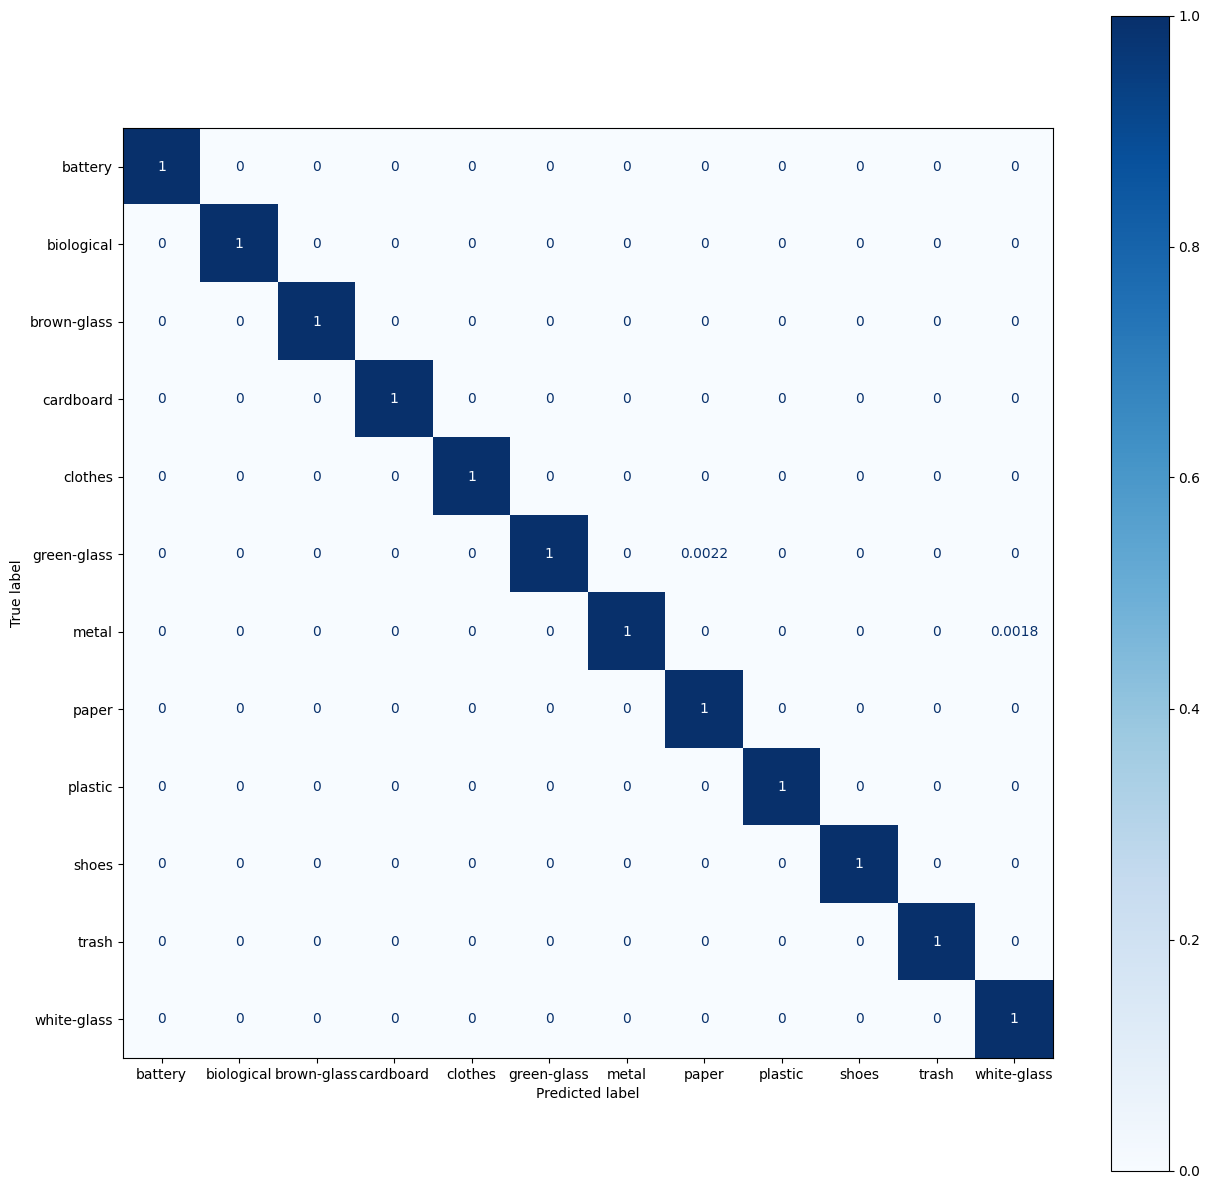

In [ ]:
# normalized confusion matrix on train
y_train_pred = model.predict(X_train)
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap='Blues', normalize='true', ax=ax)

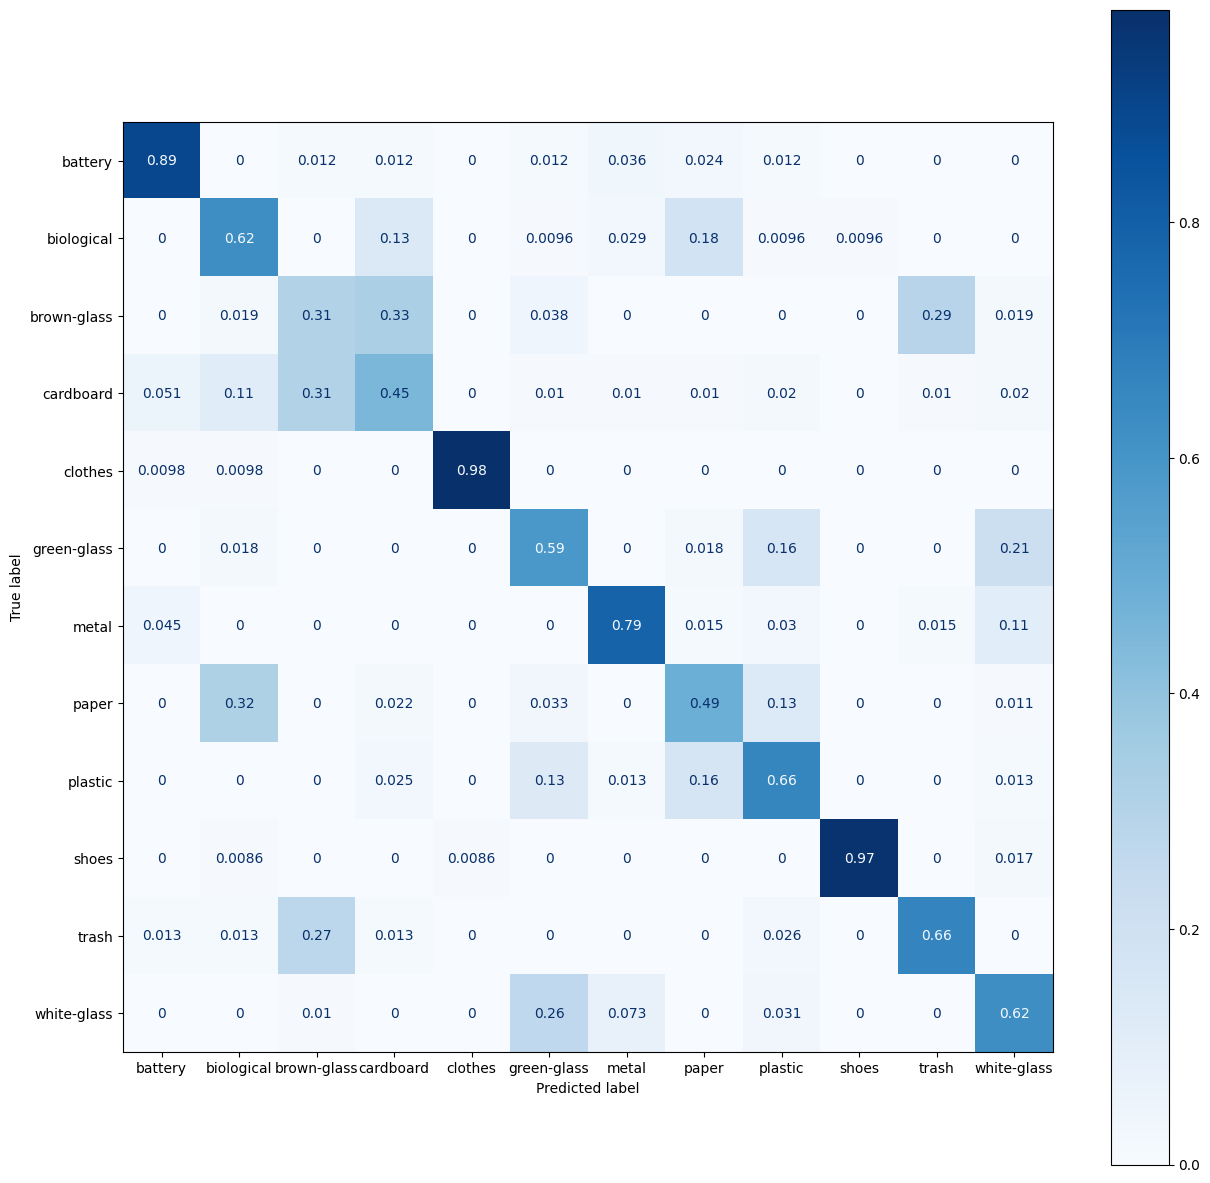

In [ ]:
# normalized confusion matrix on validation
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues', normalize='true', ax=ax)

### HOG + ResNet Concat

In [ ]:
# extract x and y variables
X_train = np.array([np.hstack([x['hog_pca'], x['resnet']]) for i, x in train.iterrows()])
y_train = np.array(train['class'])

X_val = np.array([np.hstack([x['hog_pca'], x['resnet']]) for i, x in val.iterrows()])
y_val = np.array(val['class'])

X_test = np.array([np.hstack([x['hog_pca'], x['resnet']]) for i, x in test.iterrows()])
y_test = np.array(test['class'])

In [ ]:
# train logistic regression model
model = LogisticRegression(solver='liblinear', max_iter=2000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000, solver='liblinear')

In [ ]:
# validation set predictions, accuracy, and classification report
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, model.predict(X_val)))

Accuracy: 0.7482859941234085

Classification Report:

              precision    recall  f1-score   support

     battery       0.87      0.90      0.89        83
  biological       0.64      0.68      0.66       104
 brown-glass       0.53      0.46      0.49        52
   cardboard       0.69      0.68      0.69        98
     clothes       0.99      0.98      0.99       102
 green-glass       0.45      0.55      0.50        56
       metal       0.81      0.79      0.80        66
       paper       0.60      0.57      0.58        92
     plastic       0.62      0.67      0.64        79
       shoes       0.99      0.97      0.98       116
       trash       0.84      0.81      0.82        77
 white-glass       0.73      0.68      0.70        96

    accuracy                           0.75      1021
   macro avg       0.73      0.73      0.73      1021
weighted avg       0.75      0.75      0.75      1021



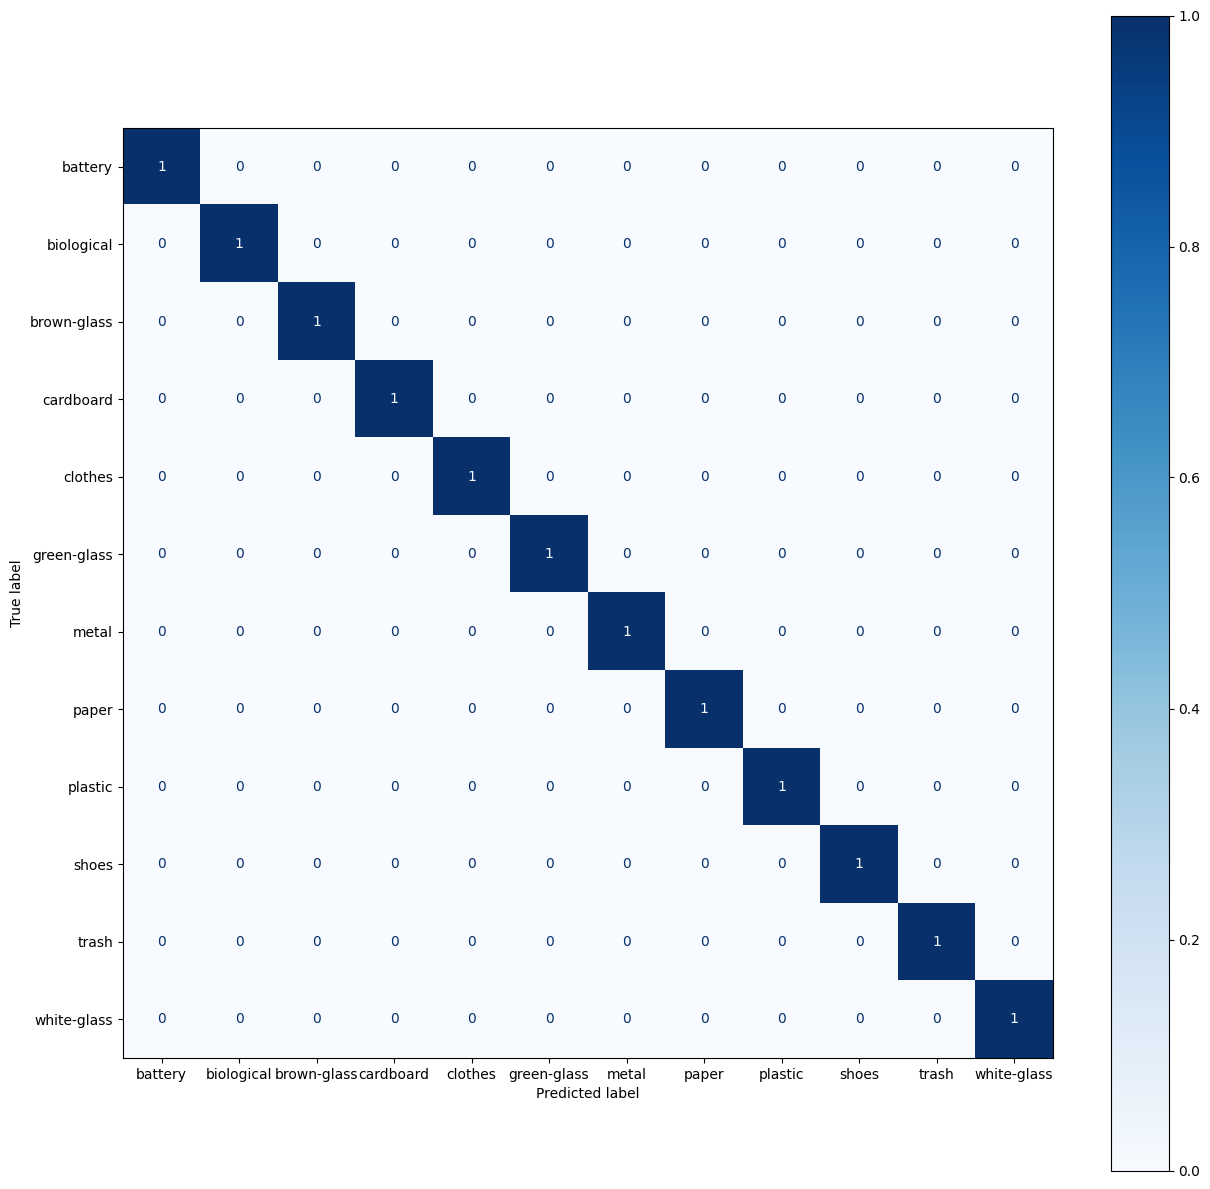

In [ ]:
# normalized confusion matrix on train
y_train_pred = model.predict(X_train)
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap='Blues', normalize='true', ax=ax)

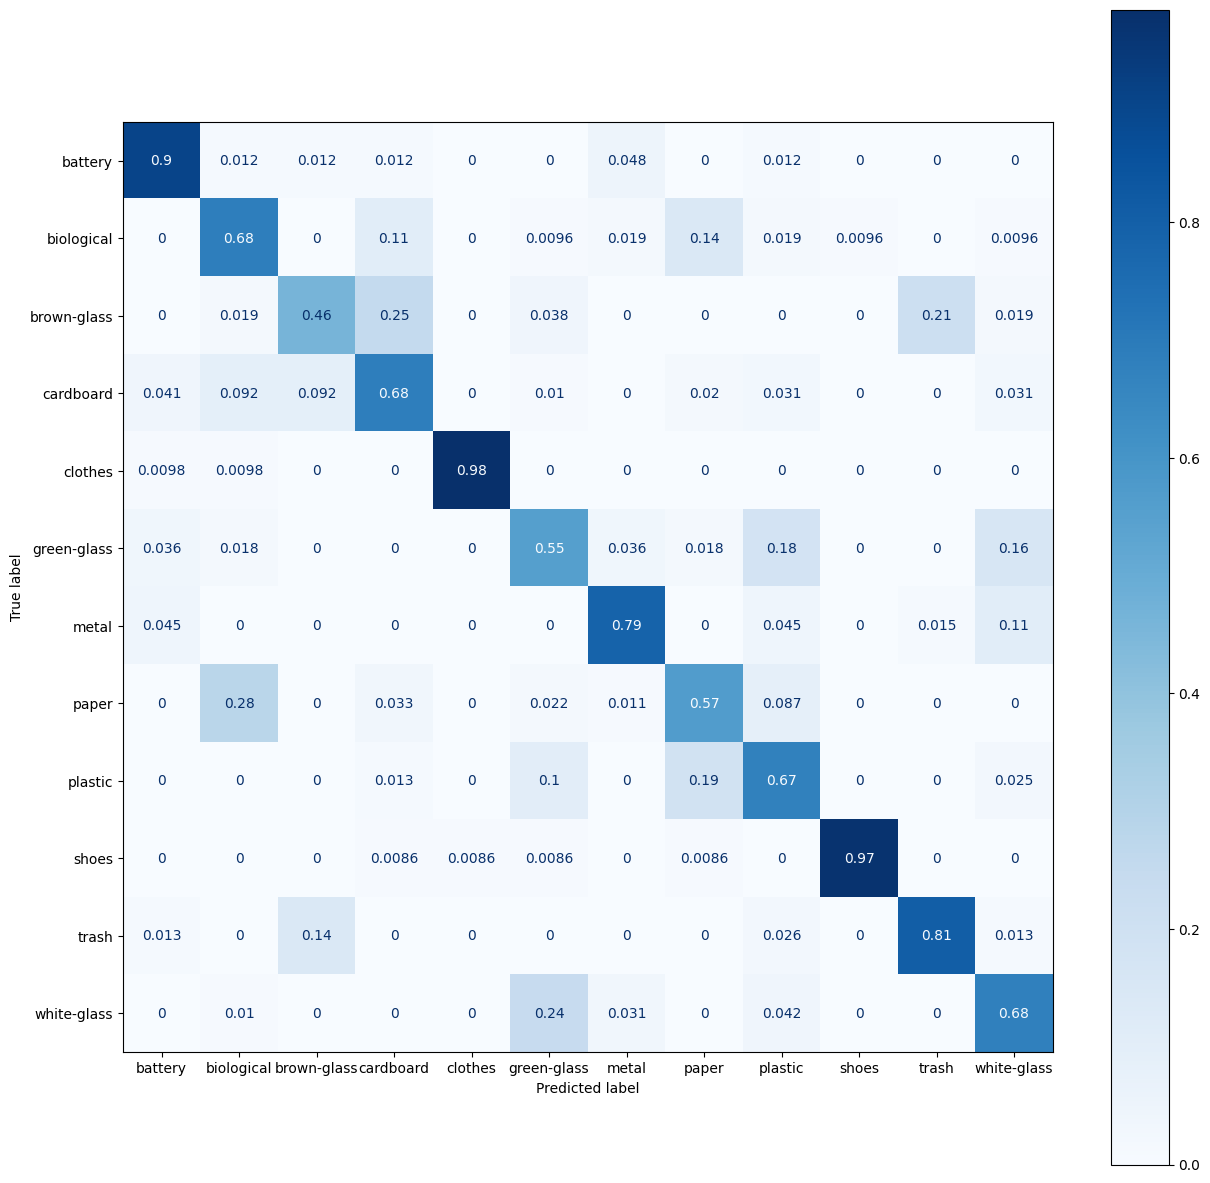

In [ ]:
# normalized confusion matrix on validation
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues', normalize='true', ax=ax)

### HOG + BOVC + ResNet Concat

In [ ]:
# extract x and y variables
X_train = np.array([np.hstack([x['hog_pca'], x['bovc'].flatten(), x['resnet']]) for i, x in train.iterrows()])
y_train = np.array(train['class'])

X_val = np.array([np.hstack([x['hog_pca'], x['bovc'].flatten(), x['resnet']]) for i, x in val.iterrows()])
y_val = np.array(val['class'])

X_test = np.array([np.hstack([x['hog_pca'], x['bovc'].flatten(), x['resnet']]) for i, x in test.iterrows()])
y_test = np.array(test['class'])

In [ ]:
# train logistic regression model
model = LogisticRegression(solver='liblinear', max_iter=2000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000, solver='liblinear')

In [ ]:
# validation set predictions, accuracy, and classification report
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, model.predict(X_val)))

Accuracy: 0.8178256611165524

Classification Report:

              precision    recall  f1-score   support

     battery       0.91      0.93      0.92        83
  biological       0.75      0.77      0.76       104
 brown-glass       0.51      0.54      0.52        52
   cardboard       0.73      0.67      0.70        98
     clothes       0.98      0.98      0.98       102
 green-glass       0.89      0.86      0.87        56
       metal       0.82      0.82      0.82        66
       paper       0.71      0.71      0.71        92
     plastic       0.69      0.75      0.72        79
       shoes       0.99      0.97      0.98       116
       trash       0.88      0.82      0.85        77
 white-glass       0.83      0.85      0.84        96

    accuracy                           0.82      1021
   macro avg       0.81      0.81      0.81      1021
weighted avg       0.82      0.82      0.82      1021



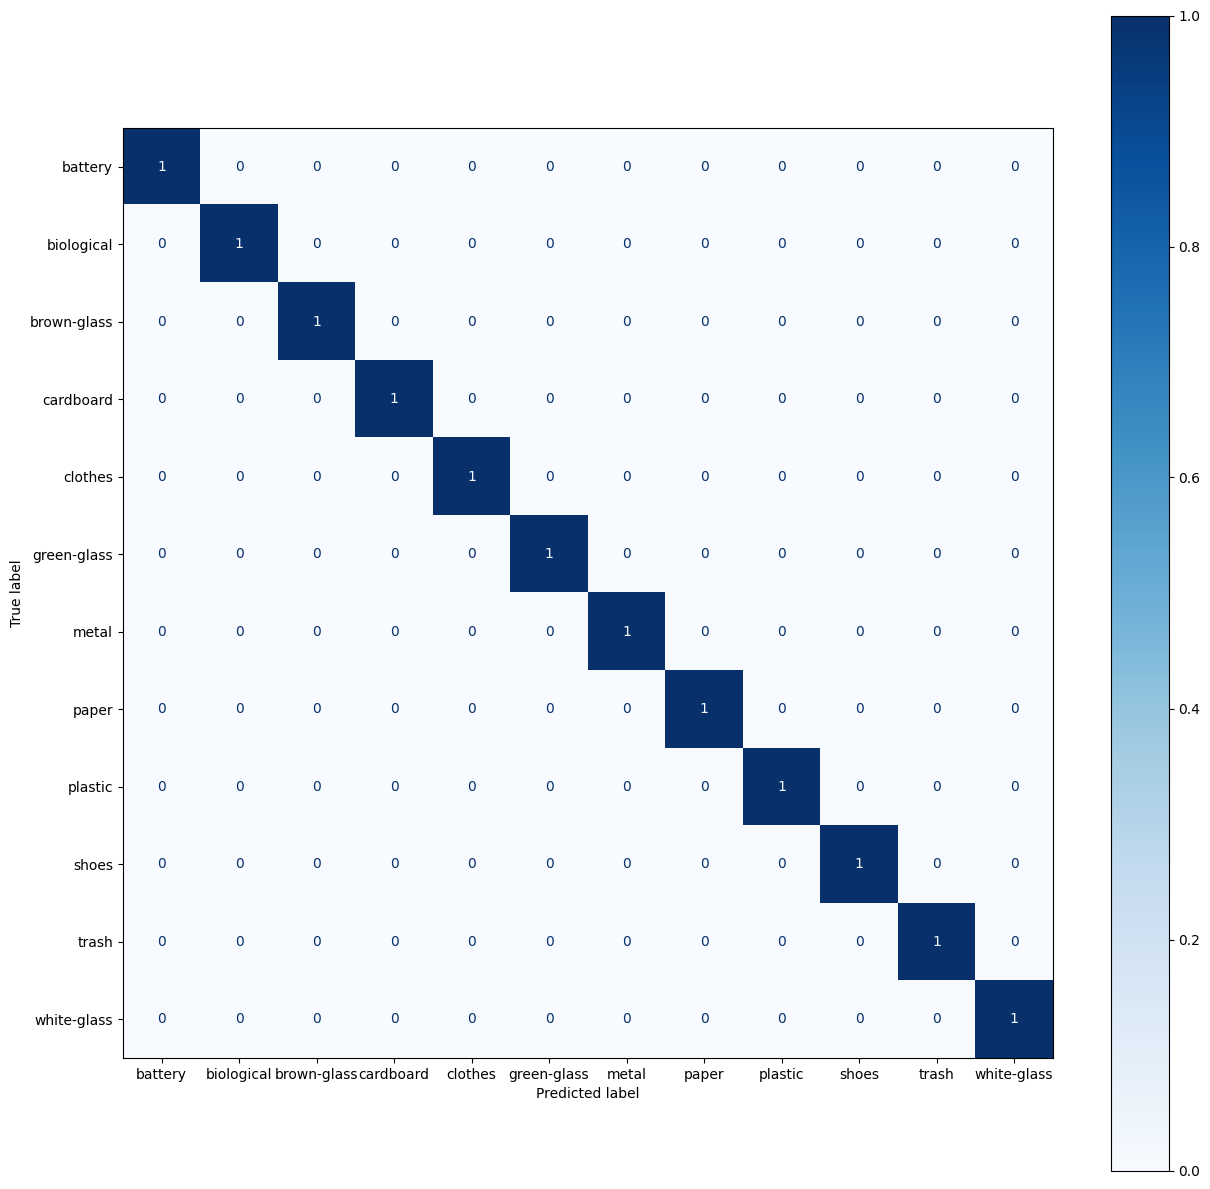

In [ ]:
# normalized confusion matrix on train
y_train_pred = model.predict(X_train)
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap='Blues', normalize='true', ax=ax)

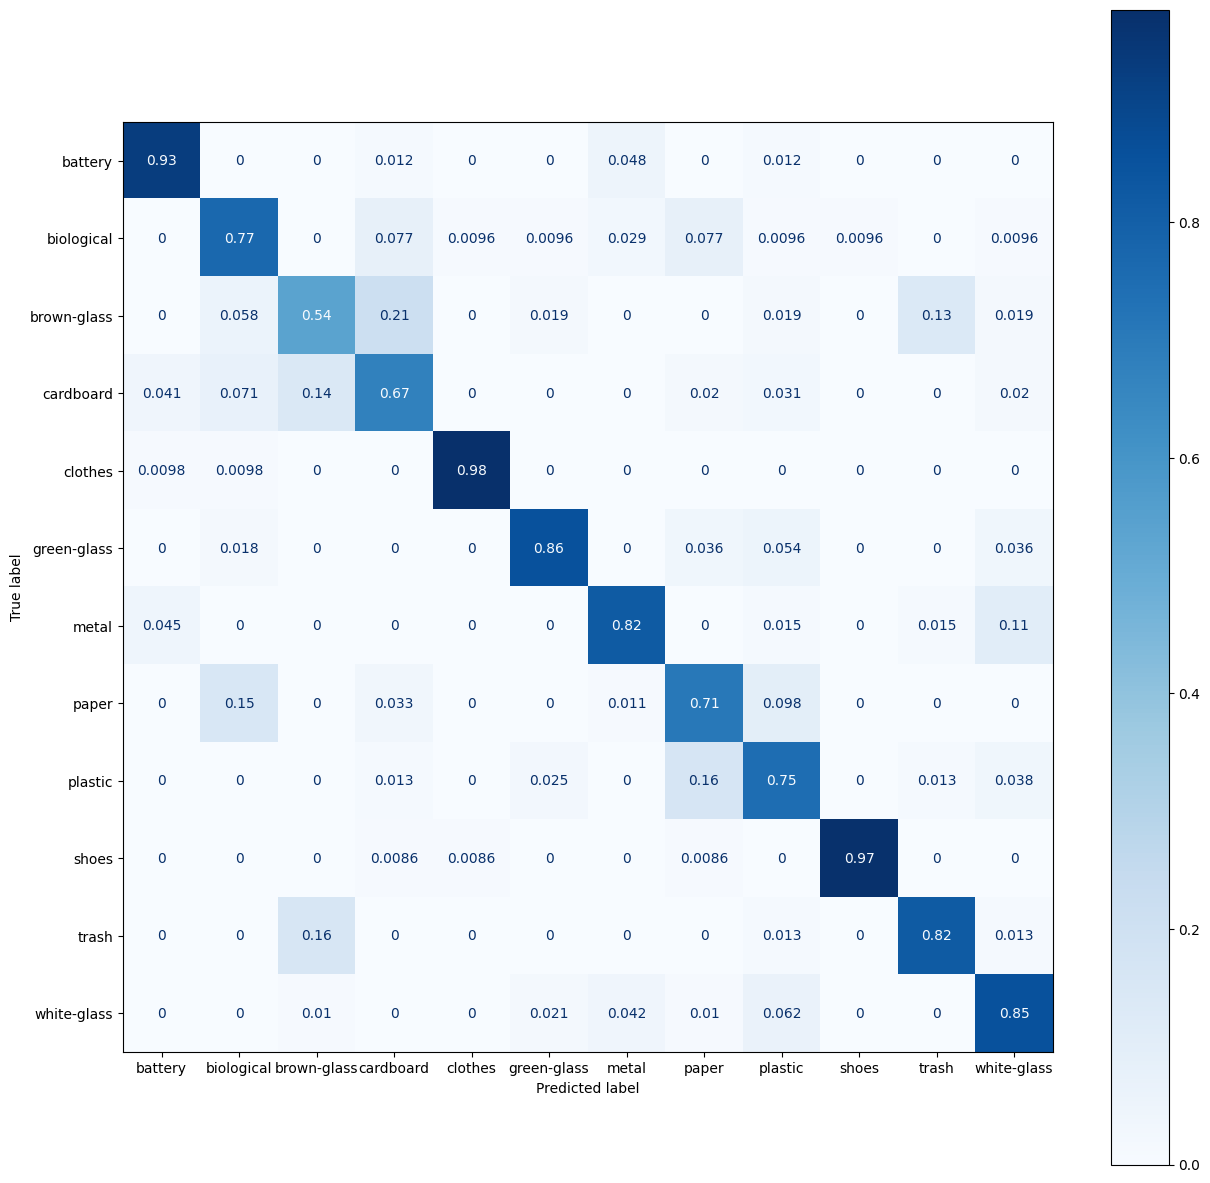

In [ ]:
# normalized confusion matrix on validation
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues', normalize='true', ax=ax)

### Hyperpamater Search

In [ ]:
# Hyperparameter search on best perfoming model
param_grid = {'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
              'multi_class': ['auto', 'ovr', 'multinomial'],
              'fit_intercept':[True, False]}
grid_search = GridSearchCV(LogisticRegression(max_iter=2000), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_
print(classification_report(y_test, best_lr.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1207, in fit
    multi_class = _check_multi_class(self.multi_class, solver, len(self.classes_))
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 90, in _check_multi_class
    raise Value

              precision    recall  f1-score   support

     battery       0.94      0.90      0.92       184
  biological       0.80      0.77      0.78       199
 brown-glass       0.65      0.60      0.62       142
   cardboard       0.66      0.71      0.69       179
     clothes       0.97      0.98      0.98       195
 green-glass       0.94      0.80      0.87       128
       metal       0.83      0.76      0.80       157
       paper       0.79      0.81      0.80       205
     plastic       0.76      0.85      0.80       168
       shoes       0.96      0.95      0.96       204
       trash       0.93      0.89      0.91       140
 white-glass       0.74      0.89      0.81       142

    accuracy                           0.83      2043
   macro avg       0.83      0.83      0.83      2043
weighted avg       0.84      0.83      0.83      2043



In [ ]:
# best performing parameters
grid_search.best_params_

{'fit_intercept': True, 'multi_class': 'auto', 'solver': 'saga'}

## Archive

###HOG

In [ ]:
X_train = np.array([list(x) for x in train['hog']])
y_train = np.array(train['class'])

X_val = np.array([list(x) for x in val['hog']])
y_val = np.array(val['class'])

X_test = np.array([list(x) for x in test['hog']])
y_test = np.array(test['class'])

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_val)
accuracy_score(y_val, y_pred)

0.4166666666666667

###PCA 50 Components

In [ ]:
# PCA
num_components = 50
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [ ]:
model = LogisticRegression()
model.fit(X_train_pca, y_train)

LogisticRegression()

In [ ]:
y_val = model.predict(X_val_pca)
accuracy_score(y_val, y_pred)

0.23333333333333334

### BOVW (Overfitting n_words = 100, k_means = 500)

In [ ]:
X_train = np.array([x.flatten() for x in train['bovw']])
y_train = np.array(train['class'])

X_val = np.array([x.flatten() for x in val['bovw']])
y_val = np.array(val['class'])

X_test = np.array([x.flatten() for x in test['bovw']])
y_test = np.array(test['class'])

In [ ]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = model.predict(X_val)
accuracy_score(y_val, y_pred)

0.23114593535749264

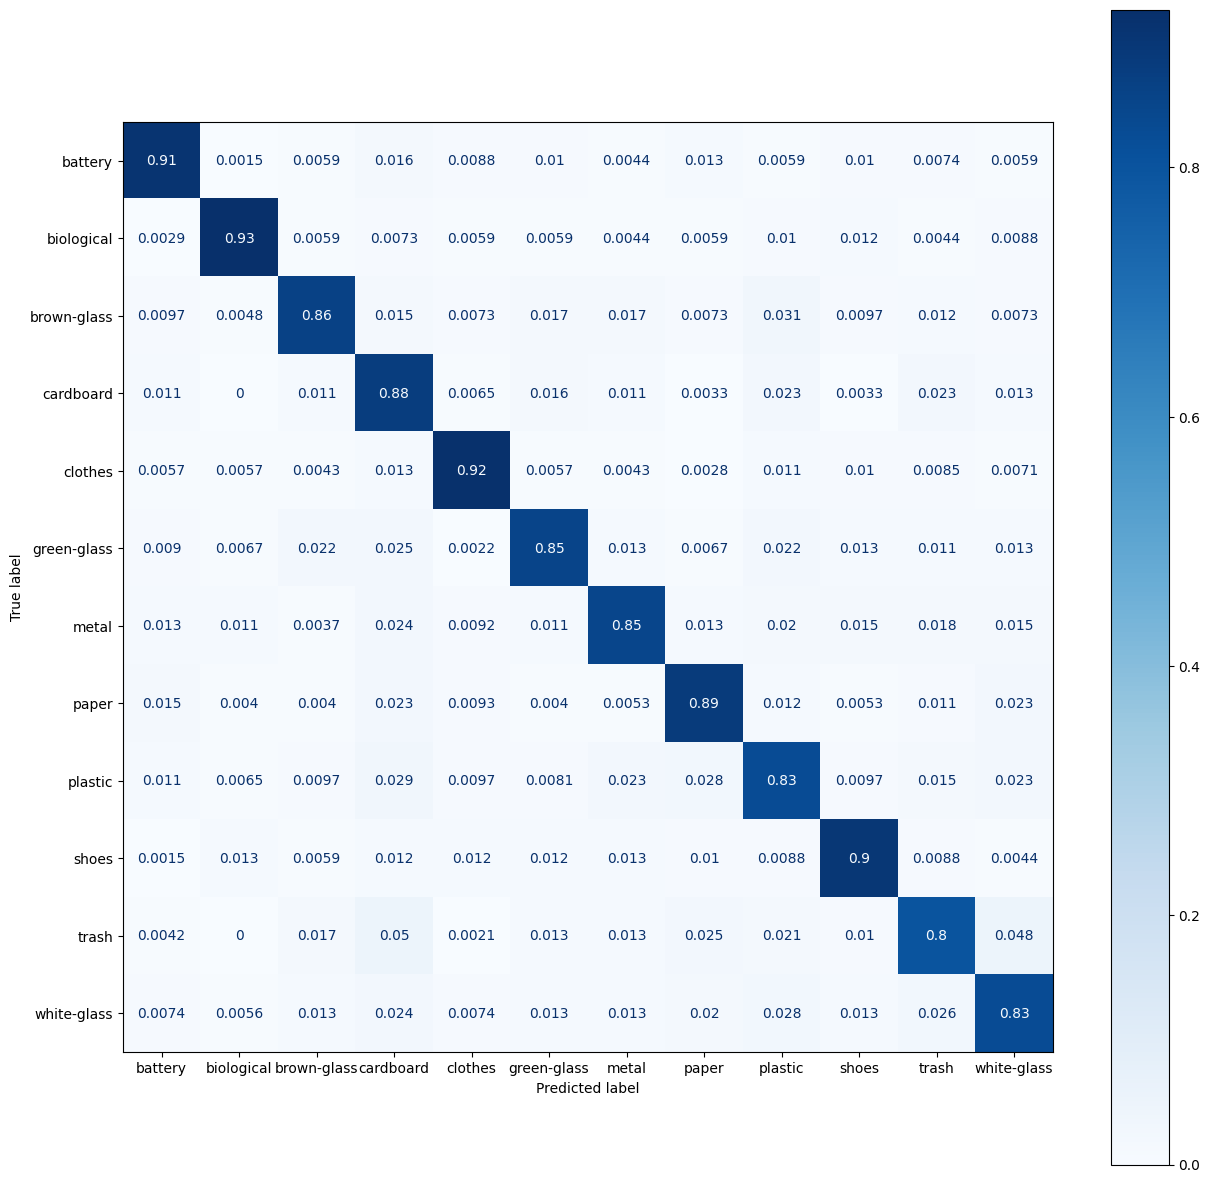

In [ ]:
# normalized confusion matrix on train
y_train_pred = model.predict(X_train)
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap='Blues', normalize='true', ax=ax)

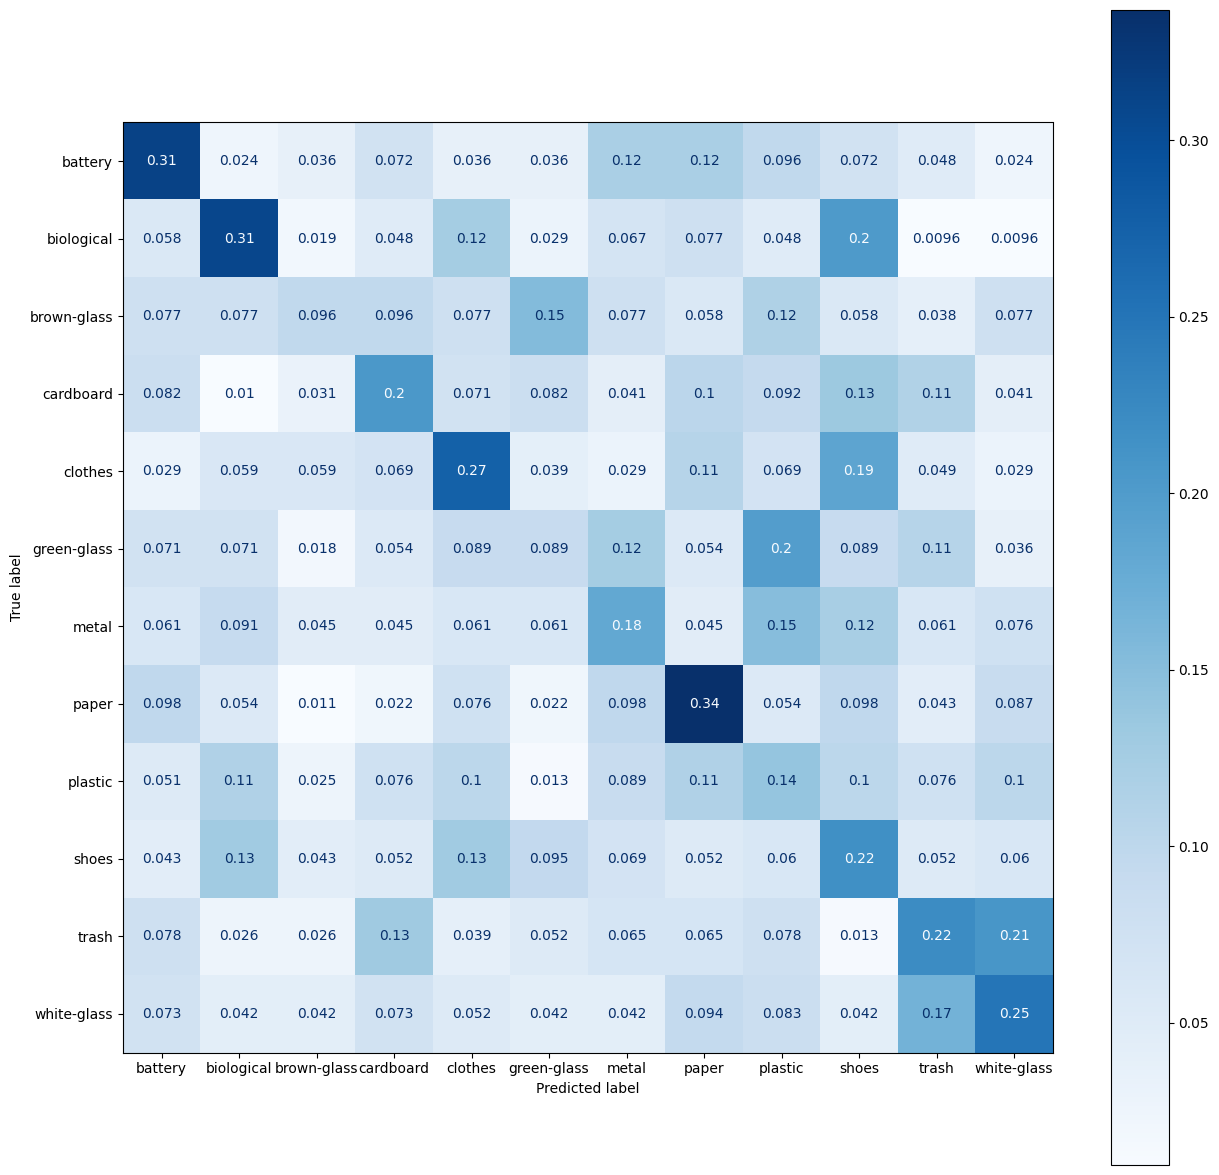

In [ ]:
# normalized confusion matrix on validation
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues', normalize='true', ax=ax)